# Intro to 2D CNNs
A description and demo notebook to go through creating a 2D CNN and using it with dummy data

## 0. Setting up dummy data

Before learning how to use the cores, let's create a dummy data images. This data will be similar to a batch of images.

Throughout the notebook we will refer to the elements of this shape in the following manner:

[1] is the number of channels (can be input, hidden, output)

[144] is the height of image or feature maps

[256] is the height of image or feature maps

[32] is the batch size, which is not as relevant for understanding the material in this notebook.

In [1]:
# To access to neuropixel_predictor
import sys
import os
sys.path.append('../')

# Basic imports
import warnings
import random

# Essential imports
import numpy as np
import torch

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

## 1. Setting Up the data

In [3]:
IMAGE_WIDTH = 36
IMAGE_HEIGHT = 22

images = torch.ones(32, 1, IMAGE_WIDTH, IMAGE_HEIGHT)


## 2. Using Stacked 2D Core

In [4]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'gamma_input': 6.3831
}

In [5]:
# from neuralpredictors.layers.cores import Stacked2dCore
# from neuralpredictors.utils import get_module_output

# core = Stacked2dCore(input_channels=1,
#                      hidden_channels=64,
#                      input_kern=9,
#                      hidden_kern=7)

# in_shape_dict = {k: get_module_output(core, in_shape)[1:] for k, in_shape in in_shapes_dict.items()}



from neuropixel_predictor.layers.cores import Stacked2dCore 

stacked2d_core = Stacked2dCore(**stacked2dcore_config)
stacked2d_core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 6.3831|skip = 0]

In [6]:
# Trying out on images
stacked2dcore_out = stacked2d_core(images)
print(stacked2dcore_out.shape)

torch.Size([32, 64, 36, 22])


## 3. Using Readout to attach Factorized Readout

In [7]:
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase

In [8]:
in_shapes_dict = {
    '2023-03-15_11-05-00': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2023-03-15_15-23': torch.Size([64, 150, 200])
}

n_neurons_dict = {
    '2023-03-15_11-05-00': 453,
    # '2023-03-15_15-23': 200
}

In [9]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

## 4. Invoke core and readout (dummy data)

In [10]:
# Forward pass with core
core_output = stacked2d_core(images)

# Forward pass with readout
readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")

readout_output_sample

tensor([[-0.0003, -0.0130, -0.0066,  ...,  0.0050, -0.0104, -0.0072],
        [-0.0003, -0.0130, -0.0066,  ...,  0.0050, -0.0104, -0.0072],
        [-0.0003, -0.0130, -0.0066,  ...,  0.0050, -0.0104, -0.0072],
        ...,
        [-0.0003, -0.0130, -0.0066,  ...,  0.0050, -0.0104, -0.0072],
        [-0.0003, -0.0130, -0.0066,  ...,  0.0050, -0.0104, -0.0072],
        [-0.0003, -0.0130, -0.0066,  ...,  0.0050, -0.0104, -0.0072]],
       grad_fn=<AddBackward0>)

## 5. Testing with test data (from sinzlab)
Utility functions from https://github.com/sinzlab/sensorium

In [11]:
# %%capture 
# !pip install git+https://github.com/sinzlab/sensorium.git

**Defining some helper functions to extract the data**

In [12]:
# # The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# # the core and readouts later on.

# def get_data(dataset_fn, dataset_config):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
#     for the original implementation and documentation if you are interested.
#     """
#     return dataset_fn(**dataset_config)

# def get_dims_for_loader_dict(dataloaders):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
#     for the original implementation and docstring if you are interested.
#     """
    
#     def get_io_dims(data_loader):
#         items = next(iter(data_loader))
#         if hasattr(items, "_asdict"):  # if it's a named tuple
#             items = items._asdict()

#         if hasattr(items, "items"):  # if dict like
#             return {k: v.shape for k, v in items.items()}
#         else:
#             return (v.shape for v in items)

#     return {k: get_io_dims(v) for k, v in dataloaders.items()}


# def set_random_seed(seed: int, deterministic: bool = True):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
#     for the original implementation and docstring if you are intereseted.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     if deterministic:
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch

**Loading the data**

In [13]:
# ## Load the data: you can modify this if you have stored it in another location
# from sensorium.datasets import static_loaders

# DATA_PATH = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Test/'

# filenames = [
#     DATA_PATH + 'static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
#     DATA_PATH + 'static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
#     ]

# dataset_config = {'paths': filenames,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': True,
#                  'batch_size': 32,
#                  'scale':1,
#                  'cuda': True if device == 'cuda' else False,
#                  }

# dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [14]:
# datapoint = list(dataloaders['train']['21067-10-18'])[0]
# images = datapoint[0]
# responses = datapoint[1]
# images.shape, responses.shape

**Process the data step by step**

In [15]:
# # We only need the train dataloaders to extract the session keys (could also use test or validation for this)
# train_dataloaders = dataloaders["train"]

# # Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
# example_batch = next(iter(list(train_dataloaders.values())[0]))
# in_name, out_name = (
#     list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
# )

# session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
# input_channels = [v[in_name][1] for v in session_shape_dict.values()]

# core_input_channels = (
#     list(input_channels.values())[0]
#     if isinstance(input_channels, dict)
#     else input_channels[0]
# )

**Core: Define Config Params**

In [16]:
# stacked2dcore_config = {
#     # core args
#     'input_kern': 7,
#     'hidden_kern': 5,
#     'hidden_channels': 64,
#     'layers': 3,
#     'stack': -1,
#     'pad_input': True,
#     'gamma_input': 6.3831
# }

**Core: Setting up**

In [17]:
# set_random_seed(random_seed)
# core = Stacked2dCore(
#     input_channels=core_input_channels,
#     **stacked2dcore_config,
# )
# core

**Core: Example forward pass**

In [18]:
# print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

# with torch.no_grad():
#     core_output = core(example_batch.images)
    
# print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


**Readout: Test the factorized**

In [19]:
# with torch.no_grad():
#     readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")


# print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

--------------
--------------
--------------
## 6. Testing with our data

In [20]:
from torch.utils.data import DataLoader

TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training'

# 1. Load the images and responses
training_images = np.load(os.path.join(TRAINING_DATA_DIR, 'training_images_2023-03-15_11-05.npy'))
training_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'training_responses_2023-03-15_11-05.npy'))

test_images = np.load(os.path.join(TRAINING_DATA_DIR, 'test_images_2023-03-15_11-05.npy'))
test_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'test_responses_2023-03-15_11-05.npy'))

training_images = training_images.reshape(training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# 2. Convert to tensors and typecast to float
training_images = torch.from_numpy(training_images).float()
test_images = torch.from_numpy(test_images).float()

training_responses = torch.from_numpy(training_responses).float()
test_responses = torch.from_numpy(test_responses).float()

# 3. Zip training and test
training_data = list(zip(training_images, training_responses))
test_data = list(zip(test_images, test_responses))
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

# 4. Load sample batch
images_batch, responses_batch = next(iter(train_dataloader))

# 5. Validate shape and types
training_images.shape, test_images.shape, images_batch.shape, responses_batch.shape, images_batch.type()

(torch.Size([8388, 1, 36, 22]),
 torch.Size([931, 1, 36, 22]),
 torch.Size([16, 1, 36, 22]),
 torch.Size([16, 453]),
 'torch.FloatTensor')

**Core: Define Config Params**

In [21]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 5,
    'hidden_kern': 3,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    # 'gamma_input': 6.3831
}

**Core: Setting up**

In [22]:
core = Stacked2dCore(
    **stacked2dcore_config,
)
core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

**Core: Example forward pass**

In [23]:
print(f"Sample batch shape: {images_batch.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(images_batch)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


Sample batch shape: torch.Size([16, 1, 36, 22]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([16, 64, 36, 22]) (batch_size, out_channels, out_height, out_width)


**Readout: Test the factorized**

In [24]:
with torch.no_grad():
    readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")


print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([16, 453]) (batch_size, n_neurons)


-------------
## 7. Training the model
Adopted similar usage from https://github.com/sinzlab/nnsysident/blob/master/notebooks/tutorial_mouse_models.ipynb

In [25]:
from neuropixel_predictor.training.trainers import simplified_trainer
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False, full=True)
mse_loss = nn.MSELoss()
device = 'mps'

# trainer_config_base = {"track_training": True,
#                        "device": device,
#                        "detach_core": False}

In [26]:
model = GeneralizedEncoderBase(
    core,
    factorized_readout,
    elu=True
)

In [27]:
trained_model, training_history = simplified_trainer(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    loss_fn=poisson_loss,
    device=device,
    max_epochs=100,
    patience=10 # For the early stopping
)

Epoch 1/100 (Train):   0%|                                                                               | 0/525 [00:00<?, ?it/s]

responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 0.9999417662620544 0.9615116715431213 1.033023715019226
-----
loss:  tensor(6.9597, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   0%|▏                                                                      | 1/525 [00:00<02:21,  3.71it/s]

responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 1.0633398294448853 0.12218707799911499 3.26766037940979
-----
loss:  tensor(7.1757, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 1.249946117401123 0.003354787826538086 6.268888473510742
-----
loss:  tensor(4.9055, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 1.264496088027954 0.00026428699493408203 8.391260147094727
-----
loss:  tensor(5.6980, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1638295650482178 0.0 109.92671203613281
predictions mean/min/max: 1.343169927597046 0.0003936886787414551 9.03489875793457
-----
loss:  tensor(7.3975, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   1%|▊                                                                      | 6/525 [00:00<00:26, 19.36it/s]

responses mean/min/max: 3.1595003604888916 0.0 89.9400405883789
predictions mean/min/max: 1.4788638353347778 7.271766662597656e-06 13.37802505493164
-----
loss:  tensor(7.0496, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.343909502029419 0.0 159.89340209960938
predictions mean/min/max: 1.5950299501419067 8.571147918701172e-05 12.443839073181152
-----
loss:  tensor(7.4964, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.1088342666625977 0.0 89.91008758544922
predictions mean/min/max: 1.6730995178222656 9.572505950927734e-05 10.37238597869873
-----
loss:  tensor(4.7566, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9041686058044434 0.0 139.5812530517578
predictions mean/min/max: 1.614377737045288 9.999999974752427e-07 17.838336944580078
-----
loss:  tensor(9.1978, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8166394233703613 0.0 119.8402099609375
predictions mean/min/max: 1.7546300888061523 2.533197402954

Epoch 1/100 (Train):   2%|█▌                                                                    | 12/525 [00:00<00:16, 31.37it/s]

responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 1.9311827421188354 3.4570693969726562e-06 12.532526969909668
-----
loss:  tensor(6.6210, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 2.03016996383667 2.0503997802734375e-05 11.414206504821777
-----
loss:  tensor(5.2771, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.418259859085083 0.0 169.60426330566406
predictions mean/min/max: 2.13083815574646 9.999999974752427e-07 20.687345504760742
-----
loss:  tensor(6.4465, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.220965623855591 0.0 99.56853485107422
predictions mean/min/max: 2.2025957107543945 9.999999974752427e-07 18.005390167236328
-----
loss:  tensor(5.8261, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9574809074401855 0.0 120.1201171875


Epoch 1/100 (Train):   3%|██▍                                                                   | 18/525 [00:00<00:12, 39.26it/s]

predictions mean/min/max: 2.341242790222168 5.424022674560547e-06 19.217201232910156
-----
loss:  tensor(5.5099, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0246291160583496 0.0 139.81358337402344
predictions mean/min/max: 2.4205918312072754 9.999999974752427e-07 17.02709197998047
-----
loss:  tensor(5.6063, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.711289644241333 0.0 149.7504119873047
predictions mean/min/max: 2.5114128589630127 5.543231964111328e-06 17.31615447998047
-----
loss:  tensor(5.1731, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9228768348693848 0.0 119.8402099609375
predictions mean/min/max: 2.502606153488159 9.999999974752427e-07 36.62823486328125
-----
loss:  tensor(5.7516, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2682008743286133 0.0 89.88015747070312
predictions mean/min/max: 2.665408134460449 1.3172626495361328e-05 17.00983238220215
-----
loss:  tensor(4.5242, device='mps:

Epoch 1/100 (Train):   5%|███▏                                                                  | 24/525 [00:00<00:11, 44.77it/s]

responses mean/min/max: 3.6242098808288574 0.0 199.60079956054688
predictions mean/min/max: 2.883060932159424 1.4424324035644531e-05 21.92800521850586
-----
loss:  tensor(6.2955, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.296851396560669 0.0 120.0400161743164
predictions mean/min/max: 2.9790027141571045 2.9206275939941406e-06 21.032203674316406
-----
loss:  tensor(5.7433, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2412071228027344 0.0 119.8402099609375
predictions mean/min/max: 3.0389211177825928 6.318092346191406e-06 19.913761138916016
-----
loss:  tensor(4.3940, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.063704490661621 0.0 159.62753295898438


Epoch 1/100 (Train):   6%|████                                                                  | 30/525 [00:00<00:10, 47.96it/s]

predictions mean/min/max: 3.0936057567596436 9.999999974752427e-07 26.118541717529297
-----
loss:  tensor(6.7792, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.336756706237793 0.0 110.110107421875
predictions mean/min/max: 3.1712567806243896 9.999999974752427e-07 27.729244232177734
-----
loss:  tensor(5.2646, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5207865238189697 0.0 149.70059204101562
predictions mean/min/max: 3.1763713359832764 3.993511199951172e-06 24.627878189086914
-----
loss:  tensor(5.8988, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5032174587249756 0.0 149.7504119873047
predictions mean/min/max: 3.2525787353515625 6.020069122314453e-06 29.00399398803711
-----
loss:  tensor(5.1224, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7275583744049072 0.0 129.95668029785156
predictions mean/min/max: 3.26590633392334 4.500150680541992e-05 25.32413101196289
-----
loss:  tensor(5.8348, device='mp

Epoch 1/100 (Train):   7%|████▊                                                                 | 36/525 [00:00<00:09, 49.29it/s]

responses mean/min/max: 3.383871555328369 0.0 149.8501434326172
predictions mean/min/max: 3.3079142570495605 1.0728836059570312e-06 24.00621795654297
-----
loss:  tensor(5.5931, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4881927967071533 0.0 140.0
predictions mean/min/max: 3.307316541671753 1.1324882507324219e-06 21.970821380615234
-----
loss:  tensor(4.4540, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.763470411300659 0.0 149.45201110839844
predictions mean/min/max: 3.3323254585266113 5.662441253662109e-06 22.286956787109375
-----
loss:  tensor(5.9850, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   8%|█████▌                                                                | 42/525 [00:01<00:09, 50.02it/s]

responses mean/min/max: 3.131312608718872 0.0 199.40179443359375
predictions mean/min/max: 3.2348034381866455 9.999999974752427e-07 26.855318069458008
-----
loss:  tensor(5.4820, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9061272144317627 0.0 89.88015747070312
predictions mean/min/max: 3.3177714347839355 2.2649765014648438e-06 39.46159744262695
-----
loss:  tensor(5.0568, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.53216290473938 0.0 119.80033111572266
predictions mean/min/max: 3.2355105876922607 4.708766937255859e-06 21.852169036865234
-----
loss:  tensor(5.5655, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9816930294036865 0.0 120.0400161743164
predictions mean/min/max: 3.2051734924316406 9.999999974752427e-07 25.7252254486084
-----
loss:  tensor(5.0516, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.529517889022827 0.0 119.48224639892578
predictions mean/min/max: 3.323049306869507 4.678964614868

Epoch 1/100 (Train):   9%|██████▍                                                               | 48/525 [00:01<00:09, 49.16it/s]

responses mean/min/max: 3.8499245643615723 0.0 129.87013244628906
predictions mean/min/max: 3.334683895111084 9.999999974752427e-07 33.80239486694336
-----
loss:  tensor(5.8335, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5142250061035156 0.0 140.2337188720703
predictions mean/min/max: 3.229623317718506 9.999999974752427e-07 24.195556640625
-----
loss:  tensor(4.6484, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  10%|███████▏                                                              | 54/525 [00:01<00:09, 49.37it/s]

responses mean/min/max: 2.8249855041503906 0.0 179.8800811767578
predictions mean/min/max: 3.210376501083374 9.999999974752427e-07 25.093509674072266
-----
loss:  tensor(4.8952, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.606348991394043 0.0 99.7672119140625
predictions mean/min/max: 3.205061197280884 9.999999974752427e-07 22.958993911743164
-----
loss:  tensor(4.6217, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.87309193611145 0.0 90.0
predictions mean/min/max: 3.1818697452545166 3.337860107421875e-06 29.589618682861328
-----
loss:  tensor(4.8751, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6067137718200684 0.0 110.14686584472656
predictions mean/min/max: 3.1392712593078613 2.2649765014648438e-06 29.942110061645508
-----
loss:  tensor(4.5254, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2298617362976074 0.0 109.96334838867188
predictions mean/min/max: 3.0847105979919434 9.999999974752427e-07 22.3

Epoch 1/100 (Train):  12%|████████▋                                                             | 65/525 [00:01<00:09, 49.38it/s]

responses mean/min/max: 2.6002211570739746 0.0 109.89010620117188
predictions mean/min/max: 3.0801422595977783 1.7583370208740234e-05 28.076873779296875
-----
loss:  tensor(4.4209, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7767536640167236 0.0 80.0533676147461
predictions mean/min/max: 3.103473424911499 2.014636993408203e-05 28.41370964050293
-----
loss:  tensor(4.7313, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.3015456199646 0.0 150.2504119873047
predictions mean/min/max: 3.092494487762451 9.238719940185547e-06 34.65080642700195
-----
loss:  tensor(6.0686, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6067354679107666 0.0 129.826904296875
predictions mean/min/max: 3.1488165855407715 1.1563301086425781e-05 35.56022262573242
-----
loss:  tensor(5.2366, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8610479831695557 0.0 79.86688995361328
predictions mean/min/max: 3.268141269683838 1.7881393432617188

Epoch 1/100 (Train):  15%|██████████▎                                                           | 77/525 [00:01<00:08, 51.43it/s]

tensor(6.0520, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2841155529022217 0.0 149.7504119873047
predictions mean/min/max: 3.38627028465271 0.001641690731048584 25.121320724487305
-----
loss:  tensor(5.2196, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3311898708343506 0.0 149.8501434326172
predictions mean/min/max: 3.410853147506714 6.330013275146484e-05 43.290714263916016
-----
loss:  tensor(4.7201, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.371873617172241 0.0 109.85353088378906
predictions mean/min/max: 3.4590728282928467 8.851289749145508e-05 44.07916259765625
-----
loss:  tensor(4.2752, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.895944356918335 0.0 160.16015625
predictions mean/min/max: 3.4156734943389893 0.0001735091209411621 26.1486873626709
-----
loss:  tensor(5.8604, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4255263805389404 0.0 129.826904296875
predictions m

Epoch 1/100 (Train):  16%|███████████                                                           | 83/525 [00:01<00:08, 51.48it/s]

responses mean/min/max: 3.046682119369507 0.0 199.66722106933594
predictions mean/min/max: 3.3016624450683594 0.0001862645149230957 34.10477066040039
-----
loss:  tensor(4.9013, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.651304244995117 0.0 119.8402099609375
predictions mean/min/max: 3.266833782196045 0.0001074671745300293 35.79047775268555
-----
loss:  tensor(5.5239, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.249040126800537 0.0 149.45201110839844
predictions mean/min/max: 3.2421114444732666 0.00035327672958374023 32.445045471191406
-----
loss:  tensor(5.3101, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8866217136383057 0.0 109.74393463134766
predictions mean/min/max: 3.196478843688965 0.0001087188720703125 52.602752685546875
-----
loss:  tensor(4.5973, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9896082878112793 0.0 190.190185546875
predictions mean/min/max: 3.1772875785827637 0.001623749732

Epoch 1/100 (Train):  17%|███████████▊                                                          | 89/525 [00:01<00:08, 51.61it/s]

responses mean/min/max: 3.4102046489715576 0.0 129.87013244628906
predictions mean/min/max: 2.944701910018921 0.001994490623474121 29.260351181030273
-----
loss:  tensor(5.5736, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.17523193359375 0.0 129.7405242919922
predictions mean/min/max: 2.9461214542388916 0.002597033977508545 27.168088912963867
-----
loss:  tensor(6.3093, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  18%|████████████▋                                                         | 95/525 [00:02<00:08, 50.22it/s]

responses mean/min/max: 3.0872995853424072 0.0 129.826904296875
predictions mean/min/max: 2.9779396057128906 0.0014385581016540527 28.863317489624023
-----
loss:  tensor(4.9918, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.633484125137329 0.0 110.07337951660156
predictions mean/min/max: 3.0271286964416504 0.0016722679138183594 28.7458553314209
-----
loss:  tensor(4.5179, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7640130519866943 0.0 129.826904296875
predictions mean/min/max: 3.0436387062072754 0.0012134313583374023 28.38852310180664
-----
loss:  tensor(4.5395, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.807711601257324 0.0 110.03668212890625
predictions mean/min/max: 3.0738108158111572 0.001261889934539795 29.51653480529785
-----
loss:  tensor(4.6074, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.603534460067749 0.0 129.78369140625
predictions mean/min/max: 3.0960066318511963 0.000227689743041992

Epoch 1/100 (Train):  20%|██████████████                                                       | 107/525 [00:02<00:08, 51.66it/s]

tensor(4.3784, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8327560424804688 0.0 180.30050659179688
predictions mean/min/max: 3.0658490657806396 0.0008133649826049805 43.930416107177734
-----
loss:  tensor(5.8450, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.720057964324951 0.0 89.85025024414062
predictions mean/min/max: 3.084902763366699 0.002229154109954834 29.961803436279297
-----
loss:  tensor(4.5316, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.099470376968384 0.0 139.81358337402344
predictions mean/min/max: 3.1599137783050537 0.00468599796295166 28.193700790405273
-----
loss:  tensor(4.7261, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.359370708465576 0.0 119.8402099609375
predictions mean/min/max: 3.1266517639160156 0.0016224384307861328 32.517906188964844
-----
loss:  tensor(5.2456, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7787461280822754 0.0 119.80033111572266
pre

Epoch 1/100 (Train):  23%|███████████████▋                                                     | 119/525 [00:02<00:07, 51.12it/s]

responses mean/min/max: 3.1910219192504883 0.0 119.8402099609375
predictions mean/min/max: 3.306898593902588 7.289648056030273e-05 45.06332015991211
-----
loss:  tensor(4.6641, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.058100700378418 0.0 170.170166015625
predictions mean/min/max: 3.5067436695098877 0.00010097026824951172 33.300167083740234
-----
loss:  tensor(4.7459, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.586507797241211 0.0 219.92669677734375
predictions mean/min/max: 3.3709912300109863 1.913309097290039e-05 47.601715087890625
-----
loss:  tensor(5.2355, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.14390230178833 0.0 180.12008666992188
predictions mean/min/max: 3.456908702850342 0.00026404857635498047 41.19483947753906
-----
loss:  tensor(4.8864, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1994924545288086 0.0 99.73403930664062
predictions mean/min/max: 3.5045480728149414 9.1671943664550

Epoch 1/100 (Train):  24%|████████████████▍                                                    | 125/525 [00:02<00:07, 50.92it/s]

tensor(6.8114, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5404233932495117 0.0 100.10009765625
predictions mean/min/max: 3.2378695011138916 3.1828880310058594e-05 49.23201370239258
-----
loss:  tensor(5.5609, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.968034505844116 0.0 129.6542510986328
predictions mean/min/max: 3.1858322620391846 1.0311603546142578e-05 29.893436431884766
-----
loss:  tensor(4.7435, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9926693439483643 0.0 109.78044128417969
predictions mean/min/max: 3.242771625518799 1.233816146850586e-05 30.231992721557617
-----
loss:  tensor(4.7763, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5710597038269043 0.0 139.5812530517578
predictions mean/min/max: 3.115952253341675 3.874301910400391e-06 31.243906021118164
-----
loss:  tensor(4.4617, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.473545789718628 0.0 119.68085479736328
pr

Epoch 1/100 (Train):  25%|█████████████████▏                                                   | 131/525 [00:02<00:07, 50.53it/s]

responses mean/min/max: 3.1485767364501953 0.0 109.85353088378906
predictions mean/min/max: 2.910285234451294 1.2695789337158203e-05 34.169918060302734
-----
loss:  tensor(4.8261, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8365817070007324 0.0 169.71713256835938
predictions mean/min/max: 2.8833401203155518 1.043081283569336e-05 37.03551483154297
-----
loss:  tensor(5.7724, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  26%|██████████████████                                                   | 137/525 [00:02<00:07, 50.10it/s]

responses mean/min/max: 3.121422290802002 0.0 99.93338012695312
predictions mean/min/max: 3.097466468811035 6.031990051269531e-05 31.58893585205078
-----
loss:  tensor(4.6992, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.284454822540283 0.0 129.95668029785156
predictions mean/min/max: 2.976935386657715 3.993511199951172e-06 47.93166732788086
-----
loss:  tensor(5.1954, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4635956287384033 0.0 149.8501434326172
predictions mean/min/max: 3.180398464202881 9.5367431640625e-05 33.376487731933594
-----
loss:  tensor(5.2287, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3589649200439453 0.0 129.826904296875
predictions mean/min/max: 3.117192268371582 0.0002536177635192871 30.405363082885742
-----
loss:  tensor(5.4063, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.0952954292297363 0.0 99.83361053466797
predictions mean/min/max: 3.434969425201416 3.6716461181640625e-0

Epoch 1/100 (Train):  28%|███████████████████▌                                                 | 149/525 [00:03<00:07, 49.99it/s]

responses mean/min/max: 3.243422746658325 0.0 129.95668029785156
predictions mean/min/max: 3.2385053634643555 0.0022304654121398926 32.214141845703125
-----
loss:  tensor(4.9305, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.380251407623291 0.0 190.31719970703125
predictions mean/min/max: 3.2295897006988525 0.0019415020942687988 31.938703536987305
-----
loss:  tensor(5.0432, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6928396224975586 0.0 129.91339111328125
predictions mean/min/max: 3.30517315864563 0.00023621320724487305 32.453819274902344
-----
loss:  tensor(4.5692, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.519651174545288 0.0 149.20423889160156
predictions mean/min/max: 3.333245038986206 0.00012671947479248047 34.06044387817383
-----
loss:  tensor(5.4511, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.45500111579895 0.0 109.85353088378906
predictions mean/min/max: 3.3093295097351074 0.0004670023

Epoch 1/100 (Train):  30%|████████████████████▎                                                | 155/525 [00:03<00:07, 49.49it/s]

responses mean/min/max: 4.217275142669678 0.0 189.62075805664062
predictions mean/min/max: 2.753873825073242 0.00017344951629638672 31.10289192199707
-----
loss:  tensor(6.4854, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2516534328460693 0.0 129.91339111328125
predictions mean/min/max: 2.7890169620513916 0.001941680908203125 38.68552780151367
-----
loss:  tensor(5.1932, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.923271417617798 0.0 239.0438232421875
predictions mean/min/max: 2.6969494819641113 0.0021546483039855957 34.8150634765625
-----
loss:  tensor(5.9130, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.913869619369507 0.0 159.68063354492188
predictions mean/min/max: 2.7362310886383057 0.0015373826026916504 42.56482696533203
-----
loss:  tensor(4.7004, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.015129804611206 0.0 99.9666748046875
predictions mean/min/max: 2.7233431339263916 0.0003417134284973

Epoch 1/100 (Train):  31%|█████████████████████▏                                               | 161/525 [00:03<00:07, 50.39it/s]

responses mean/min/max: 2.7745821475982666 0.0 89.91008758544922
predictions mean/min/max: 2.990506887435913 0.00021404027938842773 62.54053497314453
-----
loss:  tensor(4.2614, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4067232608795166 0.0 109.81697082519531
predictions mean/min/max: 3.120328664779663 0.0008985996246337891 38.85453796386719
-----
loss:  tensor(4.3205, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9358787536621094 0.0 99.63467407226562
predictions mean/min/max: 3.1276822090148926 0.00012195110321044922 64.2591552734375
-----
loss:  tensor(4.4221, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  32%|█████████████████████▉                                               | 167/525 [00:03<00:06, 51.75it/s]

responses mean/min/max: 3.9322359561920166 0.0 99.8668441772461
predictions mean/min/max: 3.2089521884918213 0.00040596723556518555 33.64323806762695
-----
loss:  tensor(5.5441, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.689072608947754 0.0 129.78369140625
predictions mean/min/max: 3.2740681171417236 0.0007109642028808594 35.372047424316406
-----
loss:  tensor(4.5025, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0164706707000732 0.0 119.80033111572266
predictions mean/min/max: 3.2343664169311523 0.00011712312698364258 59.587249755859375
-----
loss:  tensor(4.8756, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.656578540802002 0.0 140.09339904785156
predictions mean/min/max: 3.240889072418213 0.0002570152282714844 61.68910598754883
-----
loss:  tensor(5.2660, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.889796018600464 0.0 149.35279846191406
predictions mean/min/max: 3.2321879863739014 0.000251412391

Epoch 1/100 (Train):  33%|██████████████████████▋                                              | 173/525 [00:03<00:06, 51.53it/s]

responses mean/min/max: 2.9318835735321045 0.0 129.7405242919922
predictions mean/min/max: 3.2845618724823 0.002125859260559082 35.54877471923828
-----
loss:  tensor(4.9785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.515754461288452 0.0 109.78044128417969
predictions mean/min/max: 3.2890002727508545 0.0008096098899841309 45.2418212890625
-----
loss:  tensor(4.3288, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.881117343902588 0.0 99.8668441772461
predictions mean/min/max: 3.2577531337738037 0.0005327463150024414 46.84562301635742
-----
loss:  tensor(4.7050, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  34%|███████████████████████▌                                             | 179/525 [00:03<00:06, 51.87it/s]

responses mean/min/max: 2.5872414112091064 0.0 89.85025024414062
predictions mean/min/max: 3.2016806602478027 0.0010742545127868652 41.309452056884766
-----
loss:  tensor(4.4799, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2931790351867676 0.0 109.74393463134766
predictions mean/min/max: 3.116783857345581 0.001493692398071289 47.20382308959961
-----
loss:  tensor(4.8704, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.577937364578247 0.0 129.826904296875
predictions mean/min/max: 3.1474156379699707 0.0004456043243408203 43.71595764160156
-----
loss:  tensor(4.4398, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.043854236602783 0.0 119.88011932373047
predictions mean/min/max: 3.0980241298675537 0.0005334615707397461 41.91049575805664
-----
loss:  tensor(4.7685, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.658369541168213 0.0 79.86688995361328
predictions mean/min/max: 3.0553905963897705 0.002231895923614

Epoch 1/100 (Train):  35%|████████████████████████▎                                            | 185/525 [00:03<00:06, 50.93it/s]

tensor(4.7560, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6642112731933594 0.0 119.88011932373047
predictions mean/min/max: 2.808006763458252 0.001216292381286621 40.096317291259766
-----
loss:  tensor(4.1709, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.557859182357788 0.0 110.0
predictions mean/min/max: 2.779177188873291 0.001925826072692871 31.676149368286133
-----
loss:  tensor(4.6049, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7343544960021973 0.0 119.96001434326172
predictions mean/min/max: 2.934269666671753 0.00041371583938598633 41.1489143371582
-----
loss:  

Epoch 1/100 (Train):  36%|█████████████████████████                                            | 191/525 [00:03<00:06, 51.74it/s]

tensor(5.8613, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5186431407928467 0.0 99.93338012695312
predictions mean/min/max: 2.7071382999420166 0.00432276725769043 31.343246459960938
-----
loss:  tensor(5.3136, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2630228996276855 0.0 139.72056579589844
predictions mean/min/max: 2.9000775814056396 0.0012981891632080078 36.60260772705078
-----
loss:  tensor(5.1138, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.039658546447754 0.0 129.95668029785156
predictions mean/min/max: 2.9888224601745605 0.0013929009437561035 36.559574127197266
-----
loss:  tensor(6.1822, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4358739852905273 0.0 179.70050048828125
predictions mean/min/max: 2.864393949508667 0.001623690128326416 41.4788818359375
-----
loss:  tensor(4.2739, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.714872121810913 0.0 129.5250701904297
predi

Epoch 1/100 (Train):  39%|██████████████████████████▋                                          | 203/525 [00:04<00:06, 51.05it/s]

predictions mean/min/max: 3.1671383380889893 0.0013499259948730469 39.4097900390625
-----
loss:  tensor(4.6639, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6660878658294678 0.0 150.05001831054688
predictions mean/min/max: 3.134251356124878 0.0015764832496643066 39.29155731201172
-----
loss:  tensor(5.6661, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.902730703353882 0.0 129.91339111328125
predictions mean/min/max: 3.110617160797119 0.0017464160919189453 36.17734909057617
-----
loss:  tensor(4.6384, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.901977777481079 0.0 119.88011932373047
predictions mean/min/max: 3.2380003929138184 0.0041068196296691895 33.20151138305664
-----
loss:  tensor(4.8692, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3380062580108643 0.0 169.21035766601562
predictions mean/min/max: 3.352726936340332 0.0032186508178710938 33.46043395996094
-----
loss:  tensor(5.2876, device='mps:0

Epoch 1/100 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:04<00:06, 51.09it/s]

responses mean/min/max: 4.2928266525268555 0.0 149.70059204101562
predictions mean/min/max: 3.142362594604492 0.0013924241065979004 40.560977935791016
-----
loss:  tensor(5.9189, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1214795112609863 0.0 139.5812530517578
predictions mean/min/max: 3.100095510482788 0.0007774829864501953 39.3542594909668
-----
loss:  tensor(4.8734, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.450756788253784 0.0 239.44129943847656
predictions mean/min/max: 3.1570115089416504 0.000789344310760498 41.196712493896484
-----
loss:  tensor(5.5815, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.971151828765869 0.0 129.78369140625
predictions mean/min/max: 3.2616145610809326 0.000800788402557373 40.7579345703125
-----
loss:  tensor(4.8042, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.899635076522827 0.0 119.8402099609375
predictions mean/min/max: 3.2749693393707275 0.001068711280822754 

Epoch 1/100 (Train):  41%|████████████████████████████▎                                        | 215/525 [00:04<00:06, 50.49it/s]

tensor(4.8778, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6371564865112305 0.0 119.76048278808594
predictions mean/min/max: 3.24979567527771 0.0009627342224121094 37.32211685180664
-----
loss:  tensor(4.4746, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6377007961273193 0.0 139.72056579589844
predictions mean/min/max: 3.007274627685547 0.00044852495193481445 42.07097244262695
-----
loss:  tensor(4.8014, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6317358016967773 0.0 139.72056579589844
predictions mean/min/max: 3.086632251739502 0.0008237361907958984 37.17204666137695
-----
loss:  tensor(4.4523, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  42%|█████████████████████████████                                        | 221/525 [00:04<00:05, 50.79it/s]

responses mean/min/max: 2.715726613998413 0.0 79.81376647949219
predictions mean/min/max: 3.496624708175659 0.00027829408645629883 35.74042892456055
-----
loss:  tensor(4.6110, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.478036403656006 0.0 110.110107421875
predictions mean/min/max: 2.9629364013671875 0.0011779069900512695 34.03557205200195
-----
loss:  tensor(4.4329, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6457502841949463 0.0 99.90010070800781
predictions mean/min/max: 3.2011680603027344 0.000565946102142334 36.155887603759766
-----
loss:  tensor(4.6703, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.638408899307251 0.0 119.80033111572266
predictions mean/min/max: 2.910869836807251 0.0021353960037231445 36.10947036743164
-----
loss:  tensor(4.5607, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4636218547821045 0.0 219.70706176757812
predictions mean/min/max: 2.698848009109497 0.0005609989166259

Epoch 1/100 (Train):  43%|█████████████████████████████▊                                       | 227/525 [00:04<00:05, 51.08it/s]

responses mean/min/max: 2.3184974193573 0.0 139.90672302246094
predictions mean/min/max: 2.7416188716888428 0.0008161067962646484 35.6771125793457
-----
loss:  tensor(4.2199, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7458412647247314 0.0 189.74700927734375
predictions mean/min/max: 2.7744340896606445 0.001960456371307373 36.16045379638672
-----
loss:  tensor(5.6766, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.913975238800049 0.0 109.81697082519531
predictions mean/min/max: 2.600414514541626 0.001692652702331543 35.32514953613281
-----
loss:  tensor(4.8912, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.057828426361084 0.0 149.95001220703125
predictions mean/min/max: 3.0021748542785645 0.0007997751235961914 34.5782470703125
-----
loss:  

Epoch 1/100 (Train):  44%|██████████████████████████████▌                                      | 233/525 [00:04<00:05, 50.74it/s]

tensor(5.2033, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.758755683898926 0.0 99.93338012695312
predictions mean/min/max: 2.7526745796203613 0.0017733573913574219 32.7264518737793
-----
loss:  tensor(4.6796, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7156388759613037 0.0 100.16694641113281
predictions mean/min/max: 2.7044897079467773 0.002064049243927002 32.212371826171875
-----
loss:  tensor(4.5254, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9208645820617676 0.0 179.64071655273438
predictions mean/min/max: 2.701749563217163 0.0021822452545166016 31.496368408203125
-----
loss:  tensor(4.7006, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9790141582489014 0.0 129.7405242919922
predictions mean/min/max: 2.7108843326568604 0.0018999576568603516 31.740184783935547
-----
loss:  tensor(4.6577, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.076812505722046 0.0 89.91008758544922
pre

Epoch 1/100 (Train):  47%|████████████████████████████████▏                                    | 245/525 [00:05<00:05, 51.49it/s]

responses mean/min/max: 3.6708338260650635 0.0 169.66067504882812
predictions mean/min/max: 3.07767391204834 0.003281533718109131 44.80006790161133
-----
loss:  tensor(5.6046, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8962903022766113 0.0 170.0
predictions mean/min/max: 3.1650803089141846 0.003993034362792969 33.04500961303711
-----
loss:  tensor(5.8356, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.558654308319092 0.0 89.85025024414062
predictions mean/min/max: 3.2495932579040527 0.004790544509887695 33.21074295043945
-----
loss:  tensor(4.2930, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.469480276107788 0.0 139.81358337402344
predictions mean/min/max: 3.339695453643799 0.006897985935211182 33.397064208984375
-----
loss:  tensor(5.1671, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.934760570526123 0.0 139.53488159179688
predictions mean/min/max: 3.4743056297302246 0.0013998746871948242 34.2397308

Epoch 1/100 (Train):  48%|████████████████████████████████▉                                    | 251/525 [00:05<00:05, 51.08it/s]

responses mean/min/max: 3.412130117416382 0.0 139.81358337402344
predictions mean/min/max: 3.514660358428955 0.0005137920379638672 54.09872817993164
-----
loss:  tensor(4.7789, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0991692543029785 0.0 199.26934814453125
predictions mean/min/max: 3.524505615234375 0.0005176067352294922 39.10158920288086
-----
loss:  tensor(5.1480, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0008251667022705 0.0 119.80033111572266
predictions mean/min/max: 3.5701546669006348 6.866455078125e-05 40.84715270996094
-----
loss:  tensor(4.7721, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.23612117767334 0.0 119.88011932373047
predictions mean/min/max: 3.5475716590881348 2.396106719970703e-05 40.120033264160156
-----
loss:  tensor(5.1595, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.674077033996582 0.0 159.89340209960938
predictions mean/min/max: 3.5068554878234863 3.474950790405273

Epoch 1/100 (Train):  49%|█████████████████████████████████▊                                   | 257/525 [00:05<00:05, 50.11it/s]

tensor(4.5248, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.050070285797119 0.0 210.3505859375
predictions mean/min/max: 3.049699068069458 0.0017541050910949707 39.15467071533203
-----
loss:  tensor(4.9020, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.2762250900268555 0.0 159.73377990722656
predictions mean/min/max: 3.004317283630371 0.0016050338745117188 38.80092239379883
-----
loss:  tensor(5.9057, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4478533267974854 0.0 89.88015747070312
predictions mean/min/max: 2.9539968967437744 0.001060187816619873 40.43569564819336
-----
loss:  tensor(4.3419, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  50%|██████████████████████████████████▌                                  | 263/525 [00:05<00:05, 51.58it/s]

responses mean/min/max: 3.281430244445801 0.0 179.70050048828125
predictions mean/min/max: 2.979236125946045 0.001150667667388916 37.03008270263672
-----
loss:  tensor(4.7865, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3378310203552246 0.0 109.89010620117188
predictions mean/min/max: 2.8946468830108643 0.0014441609382629395 39.29586410522461
-----
loss:  tensor(5.1810, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5628886222839355 0.0 100.06671142578125
predictions mean/min/max: 2.9046244621276855 0.0008751749992370605 37.10486602783203
-----
loss:  tensor(4.2921, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.040394306182861 0.0 149.80026245117188
predictions mean/min/max: 2.85546875 0.0008369088172912598 37.792842864990234
-----
loss:  tensor(5.8547, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.863750457763672 0.0 130.08673095703125
predictions mean/min/max: 2.7871761322021484 0.00285947322845459 4

Epoch 1/100 (Train):  51%|███████████████████████████████████▎                                 | 269/525 [00:05<00:04, 51.33it/s]

responses mean/min/max: 2.4457290172576904 0.0 109.92671203613281
predictions mean/min/max: 2.912184715270996 0.004785656929016113 43.78623962402344
-----
loss:  tensor(4.3003, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6180641651153564 0.0 179.8800811767578
predictions mean/min/max: 3.009526491165161 0.0077250003814697266 35.07867431640625
-----
loss:  tensor(5.2941, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.429870128631592 0.0 109.85353088378906
predictions mean/min/max: 3.050975799560547 0.007311463356018066 37.03337860107422
-----
loss:  tensor(5.2534, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2125332355499268 0.0 149.8501434326172
predictions mean/min/max: 3.1409764289855957 0.0081825852394104 34.98643493652344
-----
loss:  tensor(4.8000, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  52%|████████████████████████████████████▏                                | 275/525 [00:05<00:04, 51.24it/s]

responses mean/min/max: 2.3467793464660645 0.0 99.80039978027344
predictions mean/min/max: 3.1994025707244873 0.006728768348693848 35.15470504760742
-----
loss:  tensor(4.2361, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7741403579711914 0.0 89.9400405883789
predictions mean/min/max: 3.2381513118743896 0.006339669227600098 35.10225296020508
-----
loss:  tensor(4.8707, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.275649309158325 0.0 125.82384490966797
predictions mean/min/max: 3.5334553718566895 0.0007543563842773438 49.127357482910156
-----
loss:  tensor(5.0078, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.865190267562866 0.0 160.0533447265625
predictions mean/min/max: 3.438420057296753 0.004590868949890137 39.39266586303711
-----
loss:  tensor(4.9350, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6941370964050293 0.0 149.7504119873047
predictions mean/min/max: 3.2494595050811768 0.00592082738876342

Epoch 1/100 (Train):  55%|█████████████████████████████████████▋                               | 287/525 [00:05<00:04, 52.42it/s]

responses mean/min/max: 3.563647508621216 0.0 119.96001434326172
predictions mean/min/max: 3.3159806728363037 0.0016515851020812988 38.65606689453125
-----
loss:  tensor(5.4378, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8229801654815674 0.0 110.14686584472656
predictions mean/min/max: 3.3125033378601074 0.002454698085784912 37.47737503051758
-----
loss:  tensor(4.6685, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.933816432952881 0.0 129.7405242919922
predictions mean/min/max: 3.293825149536133 0.001528322696685791 38.73310089111328
-----
loss:  tensor(4.6175, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.195837020874023 0.0 189.68385314941406
predictions mean/min/max: 3.4436886310577393 0.0010624527931213379 39.11204147338867
-----
loss:  tensor(5.7508, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.386711359024048 0.0 79.92008209228516
predictions mean/min/max: 3.2208569049835205 0.0014920830726623

Epoch 1/100 (Train):  56%|██████████████████████████████████████▌                              | 293/525 [00:05<00:04, 51.90it/s]

responses mean/min/max: 3.030813217163086 0.0 150.10006713867188
predictions mean/min/max: 3.2033746242523193 0.0012841224670410156 36.934940338134766
-----
loss:  tensor(4.7483, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8027617931365967 0.0 160.0533447265625
predictions mean/min/max: 3.3268611431121826 0.00041234493255615234 37.28814697265625
-----
loss:  tensor(4.5132, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.405146598815918 0.0 139.81358337402344
predictions mean/min/max: 3.2032909393310547 0.0005762577056884766 36.2935676574707
-----
loss:  tensor(5.0688, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.441988229751587 0.0 109.89010620117188
predictions mean/min/max: 3.189326286315918 0.0004609823226928711 36.182579040527344
-----
loss:  tensor(5.1013, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9529876708984375 0.0 129.826904296875
predictions mean/min/max: 3.1846089363098145 0.000516951084

Epoch 1/100 (Train):  57%|███████████████████████████████████████▎                             | 299/525 [00:06<00:04, 50.68it/s]

responses mean/min/max: 3.6032962799072266 0.0 179.64071655273438
predictions mean/min/max: 3.19437575340271 0.0005881786346435547 35.95089340209961
-----
loss:  tensor(5.3672, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9189093112945557 0.0 119.80033111572266
predictions mean/min/max: 3.109856367111206 0.0007253289222717285 38.48679733276367
-----
loss:  tensor(4.6260, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.958836793899536 0.0 109.89010620117188
predictions mean/min/max: 3.3519279956817627 0.0001913905143737793 36.781009674072266
-----
loss:  tensor(4.6948, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9182205200195312 0.0 139.30348205566406
predictions mean/min/max: 3.1533899307250977 0.0006836056709289551 40.20156478881836
-----
loss:  tensor(4.9795, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  58%|████████████████████████████████████████                             | 305/525 [00:06<00:04, 51.44it/s]

responses mean/min/max: 3.006568193435669 0.0 119.88011932373047
predictions mean/min/max: 3.0147061347961426 0.0011188983917236328 45.231563568115234
-----
loss:  tensor(4.6443, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.687006711959839 0.0 139.76705932617188
predictions mean/min/max: 3.16522479057312 0.00016921758651733398 49.43964385986328
-----
loss:  tensor(5.1651, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.996168851852417 0.0 100.46885681152344
predictions mean/min/max: 3.001350164413452 0.0005918145179748535 50.51504135131836
-----
loss:  tensor(5.1321, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6947126388549805 0.0 180.24032592773438
predictions mean/min/max: 3.0003926753997803 0.000535130500793457 50.7874870300293
-----
loss:  tensor(4.3211, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.426598310470581 0.0 129.826904296875
predictions mean/min/max: 3.3217244148254395 0.0001138448715209

Epoch 1/100 (Train):  59%|████████████████████████████████████████▊                            | 311/525 [00:06<00:04, 52.25it/s]

responses mean/min/max: 3.2360904216766357 0.0 149.80026245117188
predictions mean/min/max: 3.0620031356811523 0.0012001991271972656 38.83333969116211
-----
loss:  tensor(5.0958, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.328504800796509 0.0 89.9400405883789
predictions mean/min/max: 2.959972858428955 0.00031238794326782227 44.13674545288086
-----
loss:  tensor(4.0514, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.26261043548584 0.0 139.81358337402344
predictions mean/min/max: 3.0204200744628906 0.001214146614074707 36.770172119140625
-----
loss:  tensor(4.0999, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.653759002685547 0.0 129.87013244628906
predictions mean/min/max: 2.935680866241455 0.002801239490509033 39.36874008178711
-----
loss:  tensor(5.6415, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  60%|█████████████████████████████████████████▋                           | 317/525 [00:06<00:04, 51.15it/s]

responses mean/min/max: 3.3087193965911865 0.0 129.69737243652344
predictions mean/min/max: 3.0561673641204834 0.0005210041999816895 47.2449836730957
-----
loss:  tensor(4.5496, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.187518358230591 0.0 110.22044372558594
predictions mean/min/max: 2.913353681564331 0.001802980899810791 45.29719543457031
-----
loss:  tensor(3.9075, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5501816272735596 0.0 129.56809997558594
predictions mean/min/max: 3.0745692253112793 0.0006167292594909668 39.83306121826172
-----
loss:  tensor(5.6071, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6630847454071045 0.0 119.88011932373047
predictions mean/min/max: 2.996572256088257 0.0014562010765075684 35.993404388427734
-----
loss:  tensor(4.6253, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6100945472717285 0.0 159.68063354492188
predictions mean/min/max: 2.9402761459350586 0.00176525115

Epoch 1/100 (Train):  62%|██████████████████████████████████████████▍                          | 323/525 [00:06<00:03, 50.92it/s]

responses mean/min/max: 2.908151149749756 0.0 99.7672119140625
predictions mean/min/max: 2.961268901824951 0.0016956329345703125 36.335750579833984
-----
loss:  tensor(4.5929, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.013169050216675 0.0 149.60105895996094
predictions mean/min/max: 3.0974864959716797 0.0010337233543395996 37.37128448486328
-----
loss:  tensor(4.9980, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.409470558166504 0.0 159.78695678710938
predictions mean/min/max: 2.9217729568481445 0.00165480375289917 41.320194244384766
-----
loss:  tensor(5.3102, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.404592275619507 0.0 139.76705932617188
predictions mean/min/max: 3.205747127532959 0.0007041096687316895 38.297515869140625
-----
loss:  tensor(5.1317, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  63%|███████████████████████████████████████████▏                         | 329/525 [00:06<00:03, 51.40it/s]

responses mean/min/max: 2.9187095165252686 0.0 99.90010070800781
predictions mean/min/max: 3.3128130435943604 0.0007402896881103516 39.582340240478516
-----
loss:  tensor(4.7875, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.270228147506714 0.0 129.87013244628906
predictions mean/min/max: 3.0580427646636963 0.002390146255493164 34.731876373291016
-----
loss:  tensor(5.0598, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9291539192199707 0.0 150.05001831054688
predictions mean/min/max: 2.9887096881866455 0.003620326519012451 40.56508255004883
-----
loss:  tensor(4.6021, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.211700916290283 0.0 129.826904296875
predictions mean/min/max: 3.048008441925049 0.002125263214111328 46.72882843017578
-----
loss:  tensor(4.9085, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7180821895599365 0.0 129.7405242919922
predictions mean/min/max: 2.9824295043945312 0.005031347274780

Epoch 1/100 (Train):  64%|████████████████████████████████████████████                         | 335/525 [00:06<00:03, 50.86it/s]

responses mean/min/max: 3.033081293106079 0.0 109.85353088378906
predictions mean/min/max: 2.9539811611175537 0.0034717917442321777 42.18665313720703
-----
loss:  tensor(4.6962, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.975457191467285 0.0 119.8402099609375
predictions mean/min/max: 3.0690126419067383 0.006875455379486084 33.99558639526367
-----
loss:  tensor(4.8864, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5089282989501953 0.0 81.88263702392578
predictions mean/min/max: 3.0282557010650635 0.004783272743225098 45.09128952026367
-----
loss:  tensor(4.8927, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.389292240142822 0.0 139.86013793945312
predictions mean/min/max: 3.0089781284332275 0.00625532865524292 44.45872497558594
-----
loss:  tensor(6.1073, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8951234817504883 0.0 109.92671203613281
predictions mean/min/max: 3.1802690029144287 0.0105836391448974

Epoch 1/100 (Train):  65%|████████████████████████████████████████████▊                        | 341/525 [00:06<00:03, 50.67it/s]

tensor(4.4631, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.911501407623291 0.0 100.0333480834961
predictions mean/min/max: 3.392932415008545 0.013680756092071533 37.425506591796875
-----
loss:  tensor(5.6065, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5817699432373047 0.0 139.67408752441406
predictions mean/min/max: 3.392717123031616 0.010086536407470703 39.71432876586914
-----
loss:  tensor(5.1768, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5126657485961914 0.0 99.8668441772461
predictions mean/min/max: 3.5084338188171387 0.007031261920928955 54.65220260620117
-----
loss:  tensor(4.3900, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.685715675354004 0.0 219.78021240234375
predictions mean/min/max: 3.971393585205078 0.004788875579833984 39.679168701171875
-----
loss:  tensor(5.4095, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  66%|█████████████████████████████████████████████▌                       | 347/525 [00:07<00:03, 51.96it/s]

responses mean/min/max: 2.372009754180908 0.0 90.06004333496094
predictions mean/min/max: 3.667285442352295 0.004211783409118652 58.78702163696289
-----
loss:  tensor(4.0594, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.635864496231079 0.0 159.94668579101562
predictions mean/min/max: 3.659320116043091 0.001980006694793701 39.38396453857422
-----
loss:  tensor(4.4483, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.103889226913452 0.0 109.78044128417969
predictions mean/min/max: 3.54087233543396 0.002131044864654541 40.61268615722656
-----
loss:  tensor(4.6280, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.004246473312378 0.0 120.16021728515625
predictions mean/min/max: 3.441046714782715 0.0017020106315612793 61.65284729003906
-----
loss:  tensor(4.6642, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8913326263427734 0.0 129.7405242919922
predictions mean/min/max: 3.6372230052948 0.0008158087730407715 42.6

Epoch 1/100 (Train):  67%|██████████████████████████████████████████████▍                      | 353/525 [00:07<00:03, 52.09it/s]

tensor(5.2275, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4830243587493896 0.0 99.8668441772461
predictions mean/min/max: 3.311255931854248 0.0009760856628417969 38.452293395996094
-----
loss:  tensor(4.4660, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.103534460067749 0.0 109.81697082519531
predictions mean/min/max: 3.156297445297241 0.0007197856903076172 61.54179763793945
-----
loss:  tensor(4.6273, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.418560266494751 0.0 109.85353088378906
predictions mean/min/max: 3.4574320316314697 0.000778496265411377 40.183101654052734
-----
loss:  tensor(4.2036, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9575610160827637 0.0 99.83361053466797
predictions mean/min/max: 3.1580214500427246 0.00026160478591918945 36.07329177856445
-----
loss:  tensor(4.6238, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  68%|███████████████████████████████████████████████▏                     | 359/525 [00:07<00:03, 51.47it/s]

responses mean/min/max: 2.8113515377044678 0.0 109.85353088378906
predictions mean/min/max: 2.94682240486145 0.0007226467132568359 37.714752197265625
-----
loss:  tensor(4.5224, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5258023738861084 0.0 139.8042755126953
predictions mean/min/max: 2.7428882122039795 0.004728078842163086 52.67827224731445
-----
loss:  tensor(5.0830, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.388277292251587 0.0 149.65081787109375
predictions mean/min/max: 2.8231618404388428 0.004217386245727539 37.579010009765625
-----
loss:  tensor(5.3205, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2832212448120117 0.0 139.53488159179688
predictions mean/min/max: 2.9368386268615723 0.003950297832489014 60.36885452270508
-----
loss:  tensor(4.6941, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7963290214538574 0.0 89.88015747070312
predictions mean/min/max: 2.755265474319458 0.00575387477874

Epoch 1/100 (Train):  70%|███████████████████████████████████████████████▉                     | 365/525 [00:07<00:03, 51.57it/s]

responses mean/min/max: 2.717390298843384 0.0 159.4154815673828
predictions mean/min/max: 2.7531986236572266 0.011627137660980225 34.630287170410156
-----
loss:  tensor(4.4024, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.003105878829956 0.0 99.60159301757812
predictions mean/min/max: 2.8781042098999023 0.003985464572906494 58.92970657348633
-----
loss:  tensor(4.7128, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1183087825775146 0.0 99.93338012695312
predictions mean/min/max: 2.7856905460357666 0.00347059965133667 33.90670394897461
-----
loss:  tensor(5.0502, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.076961994171143 0.0 139.76705932617188
predictions mean/min/max: 2.8091299533843994 0.006120800971984863 34.70828628540039
-----
loss:  tensor(5.7350, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.231917858123779 0.0 179.8800811767578
predictions mean/min/max: 2.833477735519409 0.00953596830368042 35

Epoch 1/100 (Train):  71%|████████████████████████████████████████████████▊                    | 371/525 [00:07<00:03, 51.22it/s]

responses mean/min/max: 3.2801220417022705 0.0 129.78369140625
predictions mean/min/max: 2.8421239852905273 0.00497126579284668 35.195186614990234
-----
loss:  tensor(4.9611, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0445923805236816 0.0 209.6505889892578
predictions mean/min/max: 3.1108603477478027 0.000835120677947998 33.502315521240234
-----
loss:  tensor(4.6665, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8247013092041016 0.0 99.63467407226562
predictions mean/min/max: 3.2192060947418213 0.0019254088401794434 58.23564147949219
-----
loss:  tensor(4.2589, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.024639844894409 0.0 109.89010620117188
predictions mean/min/max: 3.0364303588867188 0.0042380690574646 57.270565032958984
-----
loss:  tensor(4.4072, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.161862850189209 0.0 119.88011932373047
predictions mean/min/max: 3.0939016342163086 0.00318598747253417

Epoch 1/100 (Train):  72%|█████████████████████████████████████████████████▌                   | 377/525 [00:07<00:03, 48.88it/s]

responses mean/min/max: 3.643965244293213 0.0 129.826904296875
predictions mean/min/max: 3.2413926124572754 0.0034923553466796875 38.46272659301758
-----
loss:  tensor(5.2919, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8487837314605713 0.0 119.68085479736328
predictions mean/min/max: 3.151154041290283 0.004595756530761719 38.66926956176758
-----
loss:  tensor(4.8150, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8442327976226807 0.0 119.8402099609375
predictions mean/min/max: 3.2341043949127197 0.0024942755699157715 38.72673034667969
-----
loss:  tensor(4.6652, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3301279544830322 0.0 139.5812530517578
predictions mean/min/max: 3.167259693145752 0.0023854970932006836 38.825157165527344
-----
loss:  tensor(5.5240, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.539159059524536 0.0 139.86013793945312
predictions mean/min/max: 3.1067299842834473 0.001402556896209

Epoch 1/100 (Train):  73%|██████████████████████████████████████████████████▏                  | 382/525 [00:07<00:03, 46.10it/s]

tensor(4.1085, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7096784114837646 0.0 119.8402099609375
predictions mean/min/max: 3.037773609161377 0.004131019115447998 37.192352294921875
-----
loss:  tensor(4.4530, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.740213632583618 0.0 99.93338012695312
predictions mean/min/max: 3.031153678894043 0.0028099417686462402 35.163963317871094
-----
loss:  tensor(4.5417, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1091597080230713 0.0 119.88011932373047
predictions mean/min/max: 2.993335247039795 0.0022599101066589355 56.07956314086914
-----
loss:  tensor(4.6511, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4015402793884277 0.0 199.60079956054688
predictions mean/min/max: 2.9076406955718994 0.004236340522766113 33.22083282470703
-----
loss:  tensor(5.1648, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  74%|██████████████████████████████████████████████████▊                  | 387/525 [00:07<00:03, 45.91it/s]

responses mean/min/max: 4.375410079956055 0.0 249.2522430419922
predictions mean/min/max: 3.0081753730773926 0.0032178163528442383 33.55208969116211
-----
loss:  tensor(6.4550, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.789924383163452 0.0 159.5214385986328
predictions mean/min/max: 2.9870824813842773 0.0006008744239807129 33.32449722290039
-----
loss:  tensor(5.8064, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2757506370544434 0.0 159.78695678710938
predictions mean/min/max: 2.9617130756378174 0.003591477870941162 32.69015884399414
-----
loss:  tensor(4.7248, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1760151386260986 0.0 109.74393463134766
predictions mean/min/max: 2.989192485809326 0.002185523509979248 32.73261642456055
-----
loss:  tensor(4.9718, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.625624656677246 0.0 170.0
predictions mean/min/max: 3.040518283843994 0.0033192038536071777 33.525135

Epoch 1/100 (Train):  75%|███████████████████████████████████████████████████▋                 | 393/525 [00:07<00:02, 48.43it/s]

predictions mean/min/max: 3.044996738433838 0.0028963088989257812 34.31317901611328
-----
loss:  tensor(5.7796, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.613222599029541 0.0 119.88011932373047
predictions mean/min/max: 3.0952670574188232 0.0002410411834716797 34.354949951171875
-----
loss:  tensor(5.2859, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.963015079498291 0.0 79.97334289550781
predictions mean/min/max: 3.1191599369049072 0.00035059452056884766 60.29063415527344
-----
loss:  tensor(4.4881, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.795797109603882 0.0 119.48224639892578
predictions mean/min/max: 3.157557249069214 0.0003832578659057617 59.49271011352539
-----
loss:  tensor(5.1318, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.636039972305298 0.0 129.78369140625
predictions mean/min/max: 3.354123830795288 0.0022675395011901855 35.40460205078125
-----
loss:  tensor(4.5012, device='mps:0', 

Epoch 1/100 (Train):  76%|████████████████████████████████████████████████████▎                | 398/525 [00:08<00:02, 48.76it/s]

responses mean/min/max: 3.5360288619995117 0.0 150.2002716064453
predictions mean/min/max: 3.29720401763916 0.00034046173095703125 61.2002067565918
-----
loss:  tensor(5.0762, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1130638122558594 0.0 139.90672302246094
predictions mean/min/max: 3.5829524993896484 0.0008884072303771973 39.461814880371094
-----
loss:  tensor(5.1228, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8762669563293457 0.0 109.78044128417969
predictions mean/min/max: 3.3870179653167725 0.0013611316680908203 62.82330322265625
-----
loss:  tensor(5.2139, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0142619609832764 0.0 129.6111602783203
predictions mean/min/max: 3.361384153366089 0.002196073532104492 61.57050704956055
-----
loss:  tensor(4.5782, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5166473388671875 0.0 130.08673095703125
predictions mean/min/max: 3.2421891689300537 0.001874268054

Epoch 1/100 (Train):  77%|█████████████████████████████████████████████████████                | 404/525 [00:08<00:02, 49.36it/s]

responses mean/min/max: 2.56978702545166 0.0 89.70099639892578
predictions mean/min/max: 3.2356996536254883 0.0004049539566040039 38.551536560058594
-----
loss:  tensor(4.3144, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.159979820251465 0.0 160.0
predictions mean/min/max: 3.2637839317321777 0.0050241947174072266 37.30904006958008
-----
loss:  tensor(4.7588, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9077064990997314 0.0 120.1201171875
predictions mean/min/max: 3.1836044788360596 0.0053484439849853516 38.713592529296875
-----
loss:  tensor(4.8695, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.068620681762695 0.0 160.1067352294922
predictions mean/min/max: 3.216304063796997 0.008241772651672363 37.20166015625
-----
loss:  tensor(5.7203, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.442073345184326 0.0 79.97334289550781
predictions mean/min/max: 3.10438871383667 0.008057355880737305 37.45550537109375


Epoch 1/100 (Train):  78%|█████████████████████████████████████████████████████▉               | 410/525 [00:08<00:02, 49.61it/s]

responses mean/min/max: 2.466493606567383 0.0 99.83361053466797
predictions mean/min/max: 3.0035393238067627 0.007218003273010254 36.890987396240234
-----
loss:  tensor(4.0940, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7198429107666016 0.0 129.69737243652344
predictions mean/min/max: 3.0027761459350586 0.007611453533172607 35.01688766479492
-----
loss:  tensor(4.4308, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6023049354553223 0.0 159.78695678710938
predictions mean/min/max: 2.9046642780303955 0.007067859172821045 55.5503044128418
-----
loss:  tensor(5.0253, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.291795253753662 0.0 109.89010620117188
predictions mean/min/max: 2.860778331756592 0.0009856820106506348 35.127593994140625
-----
loss:  tensor(5.1504, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  79%|██████████████████████████████████████████████████████▌              | 415/525 [00:08<00:02, 49.19it/s]

responses mean/min/max: 3.517744541168213 0.0 129.826904296875
predictions mean/min/max: 2.9820122718811035 0.009023487567901611 34.61635971069336
-----
loss:  tensor(5.4554, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.980386257171631 0.0 99.8668441772461
predictions mean/min/max: 2.927769184112549 0.0002110600471496582 34.174652099609375
-----
loss:  tensor(4.7117, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.883371591567993 0.0 159.8401641845703
predictions mean/min/max: 2.960418462753296 0.0032689571380615234 34.96528625488281
-----
loss:  tensor(5.5312, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.765667676925659 0.0 149.7504119873047
predictions mean/min/max: 2.889420509338379 0.0026890039443969727 35.38285827636719
-----
loss:  tensor(5.3607, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.262608051300049 0.0 109.85353088378906
predictions mean/min/max: 2.9746530055999756 0.0008853673934936523 3

Epoch 1/100 (Train):  80%|███████████████████████████████████████████████████████▎             | 421/525 [00:08<00:02, 49.88it/s]

responses mean/min/max: 4.036086559295654 0.0 178.3944549560547
predictions mean/min/max: 3.1567840576171875 0.004457414150238037 54.017547607421875
-----
loss:  tensor(5.3679, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.981771945953369 0.0 149.7504119873047
predictions mean/min/max: 3.1731069087982178 0.005355238914489746 60.096954345703125
-----
loss:  tensor(5.3690, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.339568853378296 0.0 130.08673095703125
predictions mean/min/max: 3.3924145698547363 0.0005588531494140625 37.74421691894531
-----
loss:  tensor(4.7470, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.693805694580078 0.0 219.63394165039062
predictions mean/min/max: 3.416138172149658 0.0018197894096374512 37.2779426574707
-----
loss:  tensor(5.5599, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.293195962905884 0.0 139.5812530517578
predictions mean/min/max: 3.563021659851074 0.003597617149353027

Epoch 1/100 (Train):  81%|███████████████████████████████████████████████████████▉             | 426/525 [00:08<00:01, 49.56it/s]

tensor(4.4722, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9438493251800537 0.0 149.80026245117188
predictions mean/min/max: 3.6410205364227295 0.0002740621566772461 38.94645690917969
-----
loss:  tensor(4.7402, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7436094284057617 0.0 129.95668029785156
predictions mean/min/max: 3.4669108390808105 0.0002549290657043457 40.872032165527344
-----
loss:  tensor(4.5095, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.461446762084961 0.0 139.81358337402344
predictions mean/min/max: 3.6537985801696777 0.0015200972557067871 44.561946868896484
-----
loss:  tensor(4.6157, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6724026203155518 0.0 169.4915313720703
predictions mean/min/max: 3.4524662494659424 0.0036594271659851074 44.60521697998047
-----
loss:  tensor(5.6615, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.638970375061035 0.0 109.74393463134766

Epoch 1/100 (Train):  82%|████████████████████████████████████████████████████████▊            | 432/525 [00:08<00:01, 50.73it/s]

tensor(5.0457, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2151877880096436 0.0 109.89010620117188
predictions mean/min/max: 3.283902168273926 0.0009010434150695801 58.784061431884766
-----
loss:  tensor(4.9493, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.456772804260254 0.0 100.13351440429688
predictions mean/min/max: 3.2828474044799805 0.0007922053337097168 62.155982971191406
-----
loss:  tensor(5.2869, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.060847043991089 0.0 119.8402099609375
predictions mean/min/max: 3.291106700897217 0.004354298114776611 59.2664909362793
-----
loss:  tensor(5.0380, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6342785358428955 0.0 99.93338012695312
predictions mean/min/max: 3.061021089553833 0.0024690628051757812 53.582801818847656
-----
loss:  tensor(4.1026, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  83%|█████████████████████████████████████████████████████████▌           | 438/525 [00:08<00:01, 51.88it/s]

responses mean/min/max: 2.9372570514678955 0.0 99.90010070800781
predictions mean/min/max: 3.068887710571289 0.0015916228294372559 55.681697845458984
-----
loss:  tensor(4.4854, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4559969902038574 0.0 120.0800552368164
predictions mean/min/max: 2.9935243129730225 0.002109050750732422 56.815101623535156
-----
loss:  tensor(4.9911, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.920884847640991 0.0 99.90010070800781
predictions mean/min/max: 3.004589557647705 0.003543853759765625 38.75625991821289
-----
loss:  tensor(4.4814, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.044644355773926 0.0 99.90010070800781
predictions mean/min/max: 2.912262201309204 0.0023259520530700684 41.610416412353516
-----
loss:  tensor(3.9729, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.641162633895874 0.0 109.85353088378906
predictions mean/min/max: 2.85935378074646 0.001715183258056640

Epoch 1/100 (Train):  85%|██████████████████████████████████████████████████████████▎          | 444/525 [00:08<00:01, 50.83it/s]

responses mean/min/max: 2.6087443828582764 0.0 80.1068115234375
predictions mean/min/max: 3.1526801586151123 0.0013981461524963379 41.140037536621094
-----
loss:  tensor(4.3769, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.060861587524414 0.0 119.8402099609375
predictions mean/min/max: 2.941646099090576 0.0032637715339660645 53.590087890625
-----
loss:  tensor(4.6206, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7234742641448975 0.0 169.43521118164062
predictions mean/min/max: 3.0438039302825928 0.0019720792770385742 36.300846099853516
-----
loss:  tensor(5.4866, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7287135124206543 0.0 200.26702880859375
predictions mean/min/max: 3.0274810791015625 0.004370987415313721 34.60403823852539
-----
loss:  tensor(4.5296, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.470794439315796 0.0 129.95668029785156
predictions mean/min/max: 3.081073760986328 0.003661870956420

Epoch 1/100 (Train):  86%|███████████████████████████████████████████████████████████▏         | 450/525 [00:09<00:01, 51.53it/s]

responses mean/min/max: 2.9165420532226562 0.0 109.59813690185547
predictions mean/min/max: 3.119002103805542 0.0042920708656311035 35.28805923461914
-----
loss:  tensor(4.4766, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.264702320098877 0.0 120.16021728515625
predictions mean/min/max: 3.1556010246276855 0.00451505184173584 36.90185546875
-----
loss:  tensor(4.7420, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5229873657226562 0.0 169.7736358642578
predictions mean/min/max: 3.157630681991577 0.004937469959259033 38.03485107421875
-----
loss:  tensor(5.1784, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7618632316589355 0.0 119.80033111572266
predictions mean/min/max: 3.1485557556152344 0.0015149712562561035 54.70396041870117
-----
loss:  tensor(4.4442, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.184582710266113 0.0 99.90010070800781
predictions mean/min/max: 3.372941493988037 0.0008178949356079102 

Epoch 1/100 (Train):  87%|███████████████████████████████████████████████████████████▉         | 456/525 [00:09<00:01, 52.15it/s]

responses mean/min/max: 2.8376011848449707 0.0 139.81358337402344
predictions mean/min/max: 3.17877459526062 0.0009796619415283203 55.04254913330078
-----
loss:  tensor(4.6128, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.863959789276123 0.0 89.88015747070312
predictions mean/min/max: 3.256028175354004 0.005156040191650391 36.962432861328125
-----
loss:  tensor(4.4535, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.864952564239502 0.0 119.80033111572266
predictions mean/min/max: 3.2620418071746826 0.0008779168128967285 56.4710578918457
-----
loss:  tensor(4.4148, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.430224657058716 0.0 129.91339111328125
predictions mean/min/max: 3.2826571464538574 0.003735065460205078 36.070613861083984
-----
loss:  tensor(5.1999, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.798923969268799 0.0 99.90010070800781
predictions mean/min/max: 3.3048810958862305 0.00116521120071411

Epoch 1/100 (Train):  88%|████████████████████████████████████████████████████████████▋        | 462/525 [00:09<00:01, 52.67it/s]

responses mean/min/max: 2.864691972732544 0.0 109.81697082519531
predictions mean/min/max: 3.1992084980010986 0.0007007718086242676 54.7000617980957
-----
loss:  tensor(4.3430, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.475621461868286 0.0 160.32064819335938
predictions mean/min/max: 3.254559278488159 0.0005233287811279297 57.51254653930664
-----
loss:  tensor(5.0055, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8910884857177734 0.0 189.74700927734375
predictions mean/min/max: 3.378913640975952 0.000997781753540039 39.572994232177734
-----
loss:  tensor(5.5942, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.892401933670044 0.0 129.5250701904297
predictions mean/min/max: 3.277395486831665 0.001712203025817871 37.22710037231445
-----
loss:  tensor(4.4547, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4326963424682617 0.0 89.9400405883789
predictions mean/min/max: 3.304490804672241 0.001306295394897461 

Epoch 1/100 (Train):  89%|█████████████████████████████████████████████████████████████▌       | 468/525 [00:09<00:01, 50.64it/s]

responses mean/min/max: 3.27775502204895 0.0 159.73377990722656
predictions mean/min/max: 3.277498960494995 0.0021431446075439453 37.96654510498047
-----
loss:  tensor(4.8694, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.74297833442688 0.0 109.89010620117188
predictions mean/min/max: 3.2317376136779785 0.004579424858093262 36.54059600830078
-----
loss:  tensor(4.5639, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.308702230453491 0.0 129.826904296875
predictions mean/min/max: 3.1921682357788086 0.008217036724090576 35.436805725097656
-----
loss:  tensor(4.9196, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0401721000671387 0.0 120.0400161743164
predictions mean/min/max: 3.1412436962127686 0.008557498455047607 58.76953887939453
-----
loss:  tensor(4.6611, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0619771480560303 0.0 99.10802459716797
predictions mean/min/max: 3.0941784381866455 0.0048604607582092285

Epoch 1/100 (Train):  90%|██████████████████████████████████████████████████████████████▎      | 474/525 [00:09<00:01, 49.48it/s]

responses mean/min/max: 3.4359631538391113 0.0 139.72056579589844
predictions mean/min/max: 3.1270592212677 0.005460083484649658 38.48784637451172
-----
loss:  tensor(5.0253, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.729922294616699 0.0 159.68063354492188
predictions mean/min/max: 3.369964122772217 0.005555152893066406 38.038883209228516
-----
loss:  tensor(5.2073, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0643205642700195 0.0 149.8501434326172
predictions mean/min/max: 3.104185104370117 0.007590174674987793 37.45161056518555
-----
loss:  tensor(4.6332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.643923282623291 0.0 100.0333480834961
predictions mean/min/max: 2.9666733741760254 0.0032735466957092285 59.253028869628906
-----
loss:  tensor(4.9390, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4276909828186035 0.0 119.80033111572266
predictions mean/min/max: 3.036311626434326 0.006801247596740723

Epoch 1/100 (Train):  91%|███████████████████████████████████████████████████████████████      | 480/525 [00:09<00:00, 50.76it/s]

responses mean/min/max: 3.1359071731567383 0.0 159.8401641845703
predictions mean/min/max: 3.3046107292175293 0.004400134086608887 40.01386260986328
-----
loss:  tensor(5.0575, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6842000484466553 0.0 140.18692016601562
predictions mean/min/max: 3.1121490001678467 0.006347537040710449 36.95501708984375
-----
loss:  tensor(4.2480, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7310197353363037 0.0 89.9400405883789
predictions mean/min/max: 2.952195405960083 0.005998790264129639 36.36539840698242
-----
loss:  tensor(4.5368, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.786303758621216 0.0 109.89010620117188
predictions mean/min/max: 3.0189595222473145 0.0054587721824646 35.214637756347656
-----
loss:  tensor(4.5159, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.311037302017212 0.0 159.8401641845703
predictions mean/min/max: 2.867927312850952 0.00647205114364624 39

Epoch 1/100 (Train):  93%|███████████████████████████████████████████████████████████████▊     | 486/525 [00:09<00:00, 50.63it/s]

responses mean/min/max: 2.386408805847168 0.0 119.8402099609375
predictions mean/min/max: 2.938525676727295 0.0020867586135864258 34.78845977783203
-----
loss:  tensor(4.0998, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.378576755523682 0.0 179.82017517089844
predictions mean/min/max: 2.888582706451416 0.002901136875152588 33.676475524902344
-----
loss:  tensor(6.0540, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8776612281799316 0.0 149.45201110839844
predictions mean/min/max: 2.7802865505218506 0.004201531410217285 36.96343231201172
-----
loss:  tensor(5.4467, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2087345123291016 0.0 99.73403930664062
predictions mean/min/max: 2.892909288406372 0.0041373372077941895 37.04669189453125
-----
loss:  tensor(4.1249, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.817307710647583 0.0 159.94668579101562
predictions mean/min/max: 2.991929531097412 0.00350278615951538

Epoch 1/100 (Train):  94%|████████████████████████████████████████████████████████████████▋    | 492/525 [00:09<00:00, 50.41it/s]

responses mean/min/max: 3.9911530017852783 0.0 159.68063354492188
predictions mean/min/max: 3.031621217727661 0.004028499126434326 34.87681579589844
-----
loss:  tensor(5.5189, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.408068656921387 0.0 119.88011932373047
predictions mean/min/max: 3.0723767280578613 0.002966761589050293 36.13917922973633
-----
loss:  tensor(5.8646, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4317941665649414 0.0 129.826904296875
predictions mean/min/max: 3.0627262592315674 0.0005592703819274902 54.9842643737793
-----
loss:  tensor(4.8213, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.69122052192688 0.0 149.7504119873047
predictions mean/min/max: 3.1391921043395996 0.0013761520385742188 52.193668365478516
-----
loss:  tensor(5.3201, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.218369245529175 0.0 110.0
predictions mean/min/max: 3.240020990371704 0.0035997629165649414 36.72756958

Epoch 1/100 (Train):  95%|█████████████████████████████████████████████████████████████████▍   | 498/525 [00:10<00:00, 47.62it/s]

tensor(5.0275, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1759073734283447 0.0 129.56809997558594
predictions mean/min/max: 3.4175214767456055 0.0008044242858886719 54.567779541015625
-----
loss:  tensor(4.6356, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1844024658203125 0.0 109.78044128417969
predictions mean/min/max: 3.386045455932617 0.0008063912391662598 54.39693069458008
-----
loss:  tensor(4.8074, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 1.8826179504394531 0.0 79.73422241210938
predictions mean/min/max: 3.242039918899536 0.0017435550689697266 38.760860443115234
-----
loss:  tensor(4.0309, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6710903644561768 0.0 149.70059204101562
predictions mean/min/max: 3.2790937423706055 0.0024913549423217773 36.44424819946289
-----
loss:  tensor(4.3619, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8744869232177734 0.0 119.8402099609375


Epoch 1/100 (Train):  96%|██████████████████████████████████████████████████████████████████▏  | 504/525 [00:10<00:00, 49.07it/s]

responses mean/min/max: 2.9355721473693848 0.0 140.18692016601562
predictions mean/min/max: 3.191926956176758 0.0042923688888549805 36.219722747802734
-----
loss:  tensor(4.8128, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.376723527908325 0.0 139.86013793945312
predictions mean/min/max: 3.1141440868377686 0.0026160478591918945 49.590782165527344
-----
loss:  tensor(4.2055, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.43050479888916 0.0 110.18363952636719
predictions mean/min/max: 3.073248863220215 0.0010916590690612793 50.98005676269531
-----
loss:  tensor(4.8484, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6148366928100586 0.0 89.9400405883789
predictions mean/min/max: 3.077598810195923 0.0016498565673828125 50.49124526977539
-----
loss:  tensor(4.2309, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3388872146606445 0.0 189.74700927734375
predictions mean/min/max: 3.010951280593872 0.00774210691452

Epoch 1/100 (Train):  97%|██████████████████████████████████████████████████████████████████▉  | 509/525 [00:10<00:00, 49.30it/s]

responses mean/min/max: 3.320021390914917 0.0 179.5809783935547
predictions mean/min/max: 2.856088876724243 0.005182147026062012 49.43632888793945
-----
loss:  tensor(5.0540, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.97656512260437 0.0 109.78044128417969
predictions mean/min/max: 2.9177329540252686 0.0006744265556335449 36.084468841552734
-----
loss:  tensor(4.5315, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.044809341430664 0.0 169.88674926757812
predictions mean/min/max: 2.941141366958618 0.004105031490325928 35.82735061645508
-----
loss:  tensor(4.7795, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4698100090026855 0.0 119.88011932373047
predictions mean/min/max: 2.7966575622558594 0.00023931264877319336 34.85433578491211
-----
loss:  tensor(4.2169, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9653615951538086 0.0 129.3103485107422
predictions mean/min/max: 2.8419127464294434 0.003677845001220

Epoch 1/100 (Train):  98%|███████████████████████████████████████████████████████████████████▌ | 514/525 [00:10<00:00, 49.19it/s]

responses mean/min/max: 3.2954483032226562 0.0 139.81358337402344
predictions mean/min/max: 2.7774574756622314 0.0014585256576538086 37.31831359863281
-----
loss:  tensor(4.8853, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 1.9450562000274658 0.0 99.8668441772461
predictions mean/min/max: 2.801992416381836 0.003933370113372803 33.86499786376953
-----
loss:  tensor(3.8238, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.815859794616699 0.0 109.74393463134766
predictions mean/min/max: 2.7465968132019043 0.0023882389068603516 36.50645065307617
-----
loss:  tensor(4.3498, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4924919605255127 0.0 99.83361053466797
predictions mean/min/max: 2.690664052963257 0.0025568008422851562 36.77577209472656
-----
loss:  tensor(4.0629, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.547088146209717 0.0 79.97334289550781
predictions mean/min/max: 2.644388437271118 0.00227516889572143

Epoch 1/100 (Train):  99%|████████████████████████████████████████████████████████████████████▏| 519/525 [00:10<00:00, 49.24it/s]

responses mean/min/max: 3.4105000495910645 0.0 99.90010070800781
predictions mean/min/max: 2.7003936767578125 0.0031668543815612793 44.96567153930664
-----
loss:  tensor(4.9117, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.619473695755005 0.0 139.81358337402344
predictions mean/min/max: 2.6041078567504883 0.0033507347106933594 38.628639221191406
-----
loss:  tensor(5.6408, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8298285007476807 0.0 189.81019592285156
predictions mean/min/max: 2.6217966079711914 0.00031441450119018555 40.824363708496094
-----
loss:  tensor(4.7462, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8341424465179443 0.0 129.48207092285156
predictions mean/min/max: 2.720614433288574 0.00788867473602295 36.43590545654297
-----
loss:  tensor(4.5136, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7902028560638428 0.0 139.81358337402344
predictions mean/min/max: 2.711519479751587 0.0015603303

Epoch 1/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:10<00:00, 49.25it/s]


Epoch 1: Train Loss: 4.9822, Val Loss: 4.9577


Epoch 2/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.51it/s]


Epoch 2: Train Loss: 4.6615, Val Loss: 5.1887


Epoch 3/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 91.75it/s]


Epoch 3: Train Loss: 4.5637, Val Loss: 5.3567


Epoch 4/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.98it/s]


Epoch 4: Train Loss: 4.5257, Val Loss: 5.3865


Epoch 5/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.23it/s]


Epoch 5: Train Loss: 4.4904, Val Loss: 5.2971


Epoch 6/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 94.18it/s]


Epoch 6: Train Loss: 4.4687, Val Loss: 5.2845


Epoch 7/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 94.41it/s]


Epoch 7: Train Loss: 4.4557, Val Loss: 5.2663


Epoch 8/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 94.07it/s]


Epoch 8: Train Loss: 4.4433, Val Loss: 5.2610


Epoch 9/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:06<00:00, 86.70it/s]


Epoch 9: Train Loss: 4.4305, Val Loss: 5.2603


Epoch 10/100 (Train):   1%|▊                                                                     | 6/525 [00:00<00:09, 51.99it/s]

responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 2.851667881011963 0.00028192996978759766 50.33876419067383
-----
loss:  tensor(4.1600, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 2.975074529647827 4.6372413635253906e-05 42.930946350097656
-----
loss:  tensor(4.3781, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 2.9277470111846924 0.000657200813293457 52.30787658691406
-----
loss:  tensor(3.3626, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 2.9313154220581055 0.00011670589447021484 46.56482696533203
-----
loss:  tensor(3.6300, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1638295650482178 0.0 109.92671203613281
predictions mean/min/max: 2.9607160091400146 0.00019180774

Epoch 10/100 (Train):   3%|██▎                                                                  | 18/525 [00:00<00:10, 49.74it/s]

predictions mean/min/max: 3.1304216384887695 0.0001156926155090332 58.39889144897461
-----
loss:  tensor(5.4341, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8655641078948975 0.0 99.8668441772461
predictions mean/min/max: 3.329371929168701 0.00024116039276123047 65.22657012939453
-----
loss:  tensor(5.1085, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 2.8670828342437744 0.0002625584602355957 58.63702392578125
-----
loss:  tensor(4.6508, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 2.7692692279815674 3.0040740966796875e-05 47.11134338378906
-----
loss:  tensor(4.3366, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.418259859085083 0.0 169.60426330566406
predictions mean/min/max: 3.2474021911621094 6.41942024230957e-05 63.54170227050781
-----
loss:  tensor(4.3470, device='mps

Epoch 10/100 (Train):   5%|███▋                                                                 | 28/525 [00:00<00:10, 47.42it/s]

tensor(3.6221, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6192734241485596 0.0 129.78369140625
predictions mean/min/max: 3.048596143722534 0.00020521879196166992 57.422481536865234
-----
loss:  tensor(3.8091, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.180232524871826 0.0 120.1201171875
predictions mean/min/max: 2.867852210998535 0.00018334388732910156 60.819366455078125
-----
loss:  tensor(4.2286, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3138484954833984 0.0 139.86013793945312
predictions mean/min/max: 2.9565634727478027 2.2470951080322266e-05 51.1855354309082
-----
loss:  tensor(4.4719, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6242098808288574 0.0 199.60079956054688
predictions mean/min/max: 3.376483678817749 8.398294448852539e-05 63.32742691040039
-----
loss:  tensor(4.4824, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.296851396560669 0.0 120.0400161743164
predict

Epoch 10/100 (Train):   7%|█████▏                                                               | 39/525 [00:00<00:09, 49.40it/s]

responses mean/min/max: 2.5032174587249756 0.0 149.7504119873047
predictions mean/min/max: 2.8530917167663574 5.841255187988281e-05 45.140926361083984
-----
loss:  tensor(3.8629, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7275583744049072 0.0 129.95668029785156
predictions mean/min/max: 3.256160020828247 4.482269287109375e-05 56.865447998046875
-----
loss:  tensor(4.7223, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.989564895629883 0.0 89.9400405883789
predictions mean/min/max: 3.0673136711120605 0.00016134977340698242 61.88768005371094
-----
loss:  tensor(4.5029, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6582982540130615 0.0 199.86676025390625
predictions mean/min/max: 3.139040946960449 0.0001984238624572754 59.62751770019531
-----
loss:  tensor(3.9298, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.644589900970459 0.0 99.83361053466797
predictions mean/min/max: 2.9498307704925537 7.951259613037

Epoch 10/100 (Train):  10%|██████▌                                                              | 50/525 [00:01<00:09, 49.28it/s]

responses mean/min/max: 2.9816930294036865 0.0 120.0400161743164
predictions mean/min/max: 2.728386163711548 2.5570392608642578e-05 58.67375183105469
-----
loss:  tensor(4.4468, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.529517889022827 0.0 119.48224639892578
predictions mean/min/max: 3.0283985137939453 8.690357208251953e-05 60.12052536010742
-----
loss:  tensor(4.6083, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6501388549804688 0.0 169.71713256835938
predictions mean/min/max: 3.340693950653076 2.2411346435546875e-05 63.08681869506836
-----
loss:  tensor(4.8512, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0382728576660156 0.0 209.86009216308594
predictions mean/min/max: 2.9638876914978027 3.057718276977539e-05 53.08137512207031
-----
loss:  tensor(4.5677, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7020113468170166 0.0 99.73403930664062
predictions mean/min/max: 3.2195968627929688 0.0001820325

Epoch 10/100 (Train):  11%|███████▎                                                             | 56/525 [00:01<00:09, 49.61it/s]

responses mean/min/max: 2.6067137718200684 0.0 110.14686584472656
predictions mean/min/max: 3.1784322261810303 2.09808349609375e-05 66.6040267944336
-----
loss:  tensor(3.9783, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2298617362976074 0.0 109.96334838867188
predictions mean/min/max: 3.344074010848999 2.2172927856445312e-05 72.28838348388672
-----
loss:  tensor(3.8112, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.543308734893799 0.0 129.826904296875
predictions mean/min/max: 3.253084421157837 0.00016814470291137695 64.42298889160156
-----
loss:  tensor(4.7406, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.999009370803833 0.0 129.87013244628906
predictions mean/min/max: 3.4608213901519775 0.00015401840209960938 66.6543197631836
-----
loss:  tensor(4.1002, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.655745506286621 0.0 119.88011932373047
predictions mean/min/max: 3.4710934162139893 5.66244125366210

Epoch 10/100 (Train):  13%|████████▉                                                            | 68/525 [00:01<00:08, 50.93it/s]

responses mean/min/max: 2.8610479831695557 0.0 79.86688995361328
predictions mean/min/max: 3.0109405517578125 6.794929504394531e-05 62.716957092285156
-----
loss:  tensor(3.7740, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8241801261901855 0.0 99.63467407226562
predictions mean/min/max: 2.694077968597412 0.00017213821411132812 42.61770248413086
-----
loss:  tensor(4.2434, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.561563491821289 0.0 269.82012939453125
predictions mean/min/max: 3.0170209407806396 0.00015425682067871094 59.21428298950195
-----
loss:  tensor(4.8594, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.703031301498413 0.0 130.08673095703125
predictions mean/min/max: 3.3200929164886475 4.839897155761719e-05 54.4798583984375
-----
loss:  tensor(4.8114, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.783827543258667 0.0 139.86013793945312
predictions mean/min/max: 3.2874348163604736 0.00010043382

Epoch 10/100 (Train):  15%|██████████▌                                                          | 80/525 [00:01<00:08, 51.18it/s]

responses mean/min/max: 2.4255263805389404 0.0 129.826904296875
predictions mean/min/max: 2.997746229171753 3.9517879486083984e-05 46.05218505859375
-----
loss:  tensor(3.9241, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9137165546417236 0.0 110.14686584472656
predictions mean/min/max: 3.470895528793335 0.0001550912857055664 62.70750045776367
-----
loss:  tensor(4.3467, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4902820587158203 0.0 149.7504119873047
predictions mean/min/max: 3.1471807956695557 0.00020331144332885742 60.478904724121094
-----
loss:  tensor(4.8415, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0542619228363037 0.0 129.826904296875
predictions mean/min/max: 3.567497968673706 3.653764724731445e-05 54.10173034667969
-----
loss:  tensor(4.3454, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2502222061157227 0.0 144.83102416992188
predictions mean/min/max: 3.047987699508667 0.0001111030578

Epoch 10/100 (Train):  18%|████████████                                                         | 92/525 [00:01<00:08, 49.05it/s]

predictions mean/min/max: 2.9013211727142334 8.946657180786133e-05 58.205135345458984
-----
loss:  tensor(4.9459, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0815634727478027 0.0 200.0
predictions mean/min/max: 2.906553268432617 0.00023537874221801758 46.177574157714844
-----
loss:  tensor(4.8671, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3749682903289795 0.0 109.92671203613281
predictions mean/min/max: 3.4149584770202637 2.6166439056396484e-05 61.64314270019531
-----
loss:  tensor(4.5021, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2323663234710693 0.0 119.96001434326172
predictions mean/min/max: 3.1190695762634277 0.00013893842697143555 55.5264892578125
-----
loss:  tensor(3.6856, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4866511821746826 0.0 119.56160736083984
predictions mean/min/max: 3.264521360397339 0.0006936788558959961 61.25371551513672
-----
loss:  tensor(3.9819, device='mps:0', gr

Epoch 10/100 (Train):  19%|████████████▉                                                        | 98/525 [00:01<00:08, 50.46it/s]

responses mean/min/max: 2.807711601257324 0.0 110.03668212890625
predictions mean/min/max: 3.059812068939209 0.0002715587615966797 49.93062210083008
-----
loss:  tensor(4.0658, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.603534460067749 0.0 129.78369140625
predictions mean/min/max: 2.73490047454834 0.0003026723861694336 42.305702209472656
-----
loss:  tensor(4.2932, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.068246841430664 0.0 119.96001434326172
predictions mean/min/max: 3.171018600463867 0.0006303191184997559 72.13301849365234
-----
loss:  tensor(4.0816, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.055422067642212 0.0 149.9000701904297
predictions mean/min/max: 3.0524709224700928 0.0004228949546813965 56.14296340942383
-----
loss:  tensor(4.3266, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.296902656555176 0.0 140.14013671875
predictions mean/min/max: 2.992370843887329 0.0005609393119812012 70.

Epoch 10/100 (Train):  21%|██████████████▏                                                     | 110/525 [00:02<00:08, 50.12it/s]

responses mean/min/max: 3.359370708465576 0.0 119.8402099609375
predictions mean/min/max: 2.8563332557678223 6.216764450073242e-05 52.33305358886719
-----
loss:  tensor(4.6564, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7787461280822754 0.0 119.80033111572266
predictions mean/min/max: 2.989103078842163 0.0005379915237426758 75.27588653564453
-----
loss:  tensor(4.0084, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6146607398986816 0.0 109.56175231933594
predictions mean/min/max: 3.3155503273010254 1.3470649719238281e-05 56.580970764160156
-----
loss:  tensor(4.7874, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.513507843017578 0.0 179.22335815429688
predictions mean/min/max: 3.1573100090026855 0.00013530254364013672 78.59700012207031
-----
loss:  tensor(4.3442, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.050408840179443 0.0 110.22044372558594
predictions mean/min/max: 3.3141939640045166 8.577108383

Epoch 10/100 (Train):  23%|███████████████▊                                                    | 122/525 [00:02<00:07, 51.36it/s]

responses mean/min/max: 3.1994924545288086 0.0 99.73403930664062
predictions mean/min/max: 3.5924570560455322 7.62939453125e-05 64.77360534667969
-----
loss:  tensor(4.2342, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.373861789703369 0.0 99.83361053466797
predictions mean/min/max: 3.0424017906188965 8.571147918701172e-05 55.058719635009766
-----
loss:  tensor(3.7907, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3486688137054443 0.0 110.29412078857422
predictions mean/min/max: 3.5095653533935547 3.319978713989258e-05 77.30522918701172
-----
loss:  tensor(4.7372, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5647528171539307 0.0 129.78369140625
predictions mean/min/max: 3.3725385665893555 6.979703903198242e-05 68.01978302001953
-----
loss:  tensor(4.0027, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4203286170959473 0.0 160.0533447265625
predictions mean/min/max: 3.2668418884277344 4.088878631591797e-

Epoch 10/100 (Train):  25%|█████████████████▏                                                  | 133/525 [00:02<00:08, 48.92it/s]

tensor(4.2275, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.473545789718628 0.0 119.68085479736328
predictions mean/min/max: 2.965965747833252 6.794929504394531e-06 51.05580520629883
-----
loss:  tensor(4.2214, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1575872898101807 0.0 119.76048278808594
predictions mean/min/max: 3.5898942947387695 3.6597251892089844e-05 60.47694396972656
-----
loss:  tensor(4.5612, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3504798412323 0.0 120.0400161743164
predictions mean/min/max: 3.419358253479004 8.797645568847656e-05 69.78441619873047
-----
loss:  tensor(4.0681, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.011676073074341 0.0 89.97000885009766
predictions mean/min/max: 3.396599054336548 3.045797348022461e-05 72.4844970703125
-----
loss:  tensor(3.8267, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1485767364501953 0.0 109.85353088378906
predicti

Epoch 10/100 (Train):  27%|██████████████████▋                                                 | 144/525 [00:02<00:07, 50.05it/s]

responses mean/min/max: 3.3589649200439453 0.0 129.826904296875
predictions mean/min/max: 3.0453455448150635 0.00012564659118652344 52.196266174316406
-----
loss:  tensor(4.4782, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.0952954292297363 0.0 99.83361053466797
predictions mean/min/max: 2.8767290115356445 0.0008042454719543457 65.383056640625
-----
loss:  tensor(3.5628, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5487301349639893 0.0 149.8501434326172
predictions mean/min/max: 3.252561569213867 0.00010818243026733398 61.84560775756836
-----
loss:  tensor(4.5244, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4769034385681152 0.0 180.0
predictions mean/min/max: 2.7291693687438965 0.0004973411560058594 62.39939880371094
-----
loss:  tensor(4.0158, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3885722160339355 0.0 129.826904296875
predictions mean/min/max: 3.0695960521698 0.00017982721328735352 63.42103

Epoch 10/100 (Train):  29%|███████████████████▍                                                | 150/525 [00:03<00:07, 48.79it/s]

tensor(4.9502, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.45500111579895 0.0 109.85353088378906
predictions mean/min/max: 3.1743698120117188 0.0002987980842590332 59.24889373779297
-----
loss:  tensor(4.1754, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.344259262084961 0.0 90.06004333496094
predictions mean/min/max: 2.8824198246002197 0.0003102421760559082 59.355224609375
-----
loss:  tensor(3.8160, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.1262903213500977 0.0 100.0333480834961
predictions mean/min/max: 2.7646677494049072 6.920099258422852e-05 64.20882415771484
-----
loss:  tensor(3.7523, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.390634059906006 0.0 119.8402099609375
predictions mean/min/max: 3.0616586208343506 2.4616718292236328e-05 67.13855743408203
-----
loss:  tensor(3.8201, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.564129114151001 0.0 89.85025024414062
predicti

Epoch 10/100 (Train):  31%|█████████████████████▎                                              | 165/525 [00:03<00:07, 48.56it/s]

responses mean/min/max: 3.923271417617798 0.0 239.0438232421875
predictions mean/min/max: 3.157245397567749 4.506111145019531e-05 73.39569091796875
-----
loss:  tensor(5.1745, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.913869619369507 0.0 159.68063354492188
predictions mean/min/max: 3.2080867290496826 4.0471553802490234e-05 70.970458984375
-----
loss:  tensor(4.1807, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.015129804611206 0.0 99.9666748046875
predictions mean/min/max: 2.8024826049804688 3.260374069213867e-05 53.262821197509766
-----
loss:  tensor(4.0027, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4352288246154785 0.0 179.76031494140625
predictions mean/min/max: 3.097219944000244 0.00026923418045043945 70.71649169921875
-----
loss:  tensor(4.8681, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2314391136169434 0.0 179.70050048828125
predictions mean/min/max: 3.045203685760498 3.24249267578125e

Epoch 10/100 (Train):  32%|██████████████████████                                              | 170/525 [00:03<00:07, 48.54it/s]

responses mean/min/max: 2.689072608947754 0.0 129.78369140625
predictions mean/min/max: 2.978797674179077 0.0002504587173461914 71.62765502929688
-----
loss:  tensor(4.1281, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0164706707000732 0.0 119.80033111572266
predictions mean/min/max: 2.8694164752960205 0.0006268024444580078 54.16243362426758
-----
loss:  tensor(4.3114, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.656578540802002 0.0 140.09339904785156
predictions mean/min/max: 3.1062405109405518 0.0002218484878540039 59.326087951660156
-----
loss:  tensor(4.6906, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.889796018600464 0.0 149.35279846191406
predictions mean/min/max: 3.0579206943511963 0.00021576881408691406 59.80809020996094
-----
loss:  tensor(5.4647, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6285171508789062 0.0 159.30966186523438
predictions mean/min/max: 3.07306170463562 0.00010126829147

Epoch 10/100 (Train):  34%|███████████████████████▍                                            | 181/525 [00:03<00:06, 49.35it/s]

tensor(4.0825, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2931790351867676 0.0 109.74393463134766
predictions mean/min/max: 3.0964064598083496 5.793571472167969e-05 61.19206619262695
-----
loss:  tensor(4.4610, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.577937364578247 0.0 129.826904296875
predictions mean/min/max: 2.9918582439422607 0.00013083219528198242 70.18805694580078
-----
loss:  tensor(4.1787, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.043854236602783 0.0 119.88011932373047
predictions mean/min/max: 3.131016254425049 0.00018024444580078125 45.09400177001953
-----
loss:  tensor(4.4364, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.658369541168213 0.0 79.86688995361328
predictions mean/min/max: 3.325774669647217 0.0001277327537536621 69.73892974853516
-----
loss:  tensor(4.0358, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3417694568634033 0.0 110.07337951660156
pred

Epoch 10/100 (Train):  36%|████████████████████████▋                                           | 191/525 [00:03<00:06, 48.01it/s]

responses mean/min/max: 3.7343544960021973 0.0 119.96001434326172
predictions mean/min/max: 3.1851823329925537 8.928775787353516e-05 62.153438568115234
-----
loss:  tensor(4.7490, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5186431407928467 0.0 99.93338012695312
predictions mean/min/max: 2.648289203643799 0.0010960102081298828 40.252525329589844
-----
loss:  tensor(4.9431, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2630228996276855 0.0 139.72056579589844
predictions mean/min/max: 2.968944549560547 8.690357208251953e-05 63.036712646484375
-----
loss:  tensor(4.3748, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.039658546447754 0.0 129.95668029785156
predictions mean/min/max: 3.586113214492798 0.00016307830810546875 65.84957122802734
-----
loss:  tensor(5.0949, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4358739852905273 0.0 179.70050048828125
predictions mean/min/max: 2.8953607082366943 9.67979431

Epoch 10/100 (Train):  38%|██████████████████████████                                          | 201/525 [00:04<00:07, 45.65it/s]

responses mean/min/max: 2.5064964294433594 0.0 99.8668441772461
predictions mean/min/max: 2.8931519985198975 0.00015437602996826172 43.43680953979492
-----
loss:  tensor(3.9168, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.565908908843994 0.0 119.96001434326172
predictions mean/min/max: 3.285295248031616 0.00013130903244018555 59.73259735107422
-----
loss:  tensor(4.5354, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.862340211868286 0.0 139.81358337402344
predictions mean/min/max: 2.7891743183135986 0.0001289844512939453 46.908634185791016
-----
loss:  tensor(4.2999, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6660878658294678 0.0 150.05001831054688
predictions mean/min/max: 3.1186771392822266 0.0016306042671203613 67.2677993774414
-----
loss:  tensor(5.2253, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.902730703353882 0.0 129.91339111328125
predictions mean/min/max: 3.10917067527771 0.0003713369369

Epoch 10/100 (Train):  40%|███████████████████████████▍                                        | 212/525 [00:04<00:06, 47.13it/s]

responses mean/min/max: 3.224135637283325 0.0 159.4154815673828
predictions mean/min/max: 3.1486425399780273 9.417533874511719e-05 64.24107360839844
-----
loss:  tensor(4.2957, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.233314275741577 0.0 159.362548828125
predictions mean/min/max: 2.6948845386505127 0.00019621849060058594 51.684913635253906
-----
loss:  tensor(4.8997, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.2928266525268555 0.0 149.70059204101562
predictions mean/min/max: 3.1261963844299316 0.0006921887397766113 61.221126556396484
-----
loss:  tensor(5.4626, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1214795112609863 0.0 139.5812530517578
predictions mean/min/max: 3.0514683723449707 0.0013536810874938965 64.86849212646484
-----
loss:  tensor(4.3446, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.450756788253784 0.0 239.44129943847656
predictions mean/min/max: 3.1150360107421875 0.00018405914

Epoch 10/100 (Train):  42%|████████████████████████████▉                                       | 223/525 [00:04<00:06, 48.39it/s]

responses mean/min/max: 2.6371564865112305 0.0 119.76048278808594
predictions mean/min/max: 3.1747701168060303 0.0003033280372619629 50.27793502807617
-----
loss:  tensor(3.9760, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6377007961273193 0.0 139.72056579589844
predictions mean/min/max: 3.312046766281128 0.00024497509002685547 57.98114013671875
-----
loss:  tensor(4.2182, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6317358016967773 0.0 139.72056579589844
predictions mean/min/max: 2.9452338218688965 0.0002662539482116699 55.180633544921875
-----
loss:  tensor(4.2447, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.715726613998413 0.0 79.81376647949219
predictions mean/min/max: 3.154103994369507 6.031990051269531e-05 59.977081298828125
-----
loss:  tensor(3.9805, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.478036403656006 0.0 110.110107421875
predictions mean/min/max: 2.859882354736328 0.000180602073

Epoch 10/100 (Train):  45%|██████████████████████████████▎                                     | 234/525 [00:04<00:05, 49.16it/s]

responses mean/min/max: 2.3184974193573 0.0 139.90672302246094
predictions mean/min/max: 3.070246696472168 0.00017893314361572266 58.379817962646484
-----
loss:  tensor(3.9117, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7458412647247314 0.0 189.74700927734375
predictions mean/min/max: 2.886295795440674 0.0001252293586730957 47.770347595214844
-----
loss:  tensor(5.1615, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.913975238800049 0.0 109.81697082519531
predictions mean/min/max: 2.817542791366577 0.000152587890625 54.7500114440918
-----
loss:  tensor(4.2284, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.057828426361084 0.0 149.95001220703125
predictions mean/min/max: 2.854015827178955 0.00014281272888183594 53.39555358886719
-----
loss:  tensor(4.5599, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.758755683898926 0.0 99.93338012695312
predictions mean/min/max: 2.7365782260894775 0.0001906156539916992

Epoch 10/100 (Train):  46%|██████████████████████████████▉                                     | 239/525 [00:04<00:06, 46.88it/s]

tensor(4.2463, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.333852767944336 0.0 109.81697082519531
predictions mean/min/max: 2.9975600242614746 0.000963747501373291 42.83086013793945
-----
loss:  tensor(4.5975, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6949105262756348 0.0 119.76048278808594
predictions mean/min/max: 3.1053531169891357 0.0003491044044494629 50.15907287597656
-----
loss:  tensor(4.8160, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.409144163131714 0.0 129.35324096679688
predictions mean/min/max: 3.227609157562256 0.0012305378913879395 50.731285095214844
-----
loss:  tensor(4.6753, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6708338260650635 0.0 169.66067504882812
predictions mean/min/max: 3.3091230392456055 0.001333475112915039 54.58046340942383
-----
loss:  tensor(4.7957, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8962903022766113 0.0 170.0
predictions mea

Epoch 10/100 (Train):  47%|████████████████████████████████▎                                   | 249/525 [00:05<00:06, 45.85it/s]

responses mean/min/max: 3.2505648136138916 0.0 129.826904296875
predictions mean/min/max: 3.1264562606811523 0.0007452964782714844 49.596046447753906
-----
loss:  tensor(4.3124, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3146562576293945 0.0 129.87013244628906
predictions mean/min/max: 3.1548969745635986 0.00030422210693359375 50.4490966796875
-----
loss:  tensor(5.0264, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7463605403900146 0.0 129.87013244628906
predictions mean/min/max: 3.177957773208618 0.0005043745040893555 50.78395462036133
-----
loss:  tensor(4.1150, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8542890548706055 0.0 119.8402099609375
predictions mean/min/max: 3.2964770793914795 0.0002644062042236328 66.58952331542969
-----
loss:  tensor(4.5425, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9514048099517822 0.0 129.826904296875
predictions mean/min/max: 3.1999588012695312 0.001815378665

Epoch 10/100 (Train):  50%|█████████████████████████████████▊                                  | 261/525 [00:05<00:05, 49.56it/s]

tensor(4.3149, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.563340187072754 0.0 129.7405242919922
predictions mean/min/max: 2.846956253051758 0.0007318258285522461 44.72279739379883
-----
loss:  tensor(5.3468, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.663635730743408 0.0 219.92669677734375
predictions mean/min/max: 2.903367757797241 0.0008125901222229004 54.90973663330078
-----
loss:  tensor(4.1338, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.050070285797119 0.0 210.3505859375
predictions mean/min/max: 3.250917911529541 0.0006551146507263184 61.74406433105469
-----
loss:  tensor(4.3238, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.2762250900268555 0.0 159.73377990722656
predictions mean/min/max: 3.589162588119507 0.0009312033653259277 52.43033981323242
-----
loss:  tensor(4.8947, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4478533267974854 0.0 89.88015747070312
predictions

Epoch 10/100 (Train):  52%|███████████████████████████████████▏                                | 272/525 [00:05<00:05, 47.60it/s]

predictions mean/min/max: 2.840284585952759 0.0009406208992004395 56.31375503540039
-----
loss:  tensor(6.1668, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.835784912109375 0.0 140.0466766357422
predictions mean/min/max: 3.061353921890259 0.0002802610397338867 54.158809661865234
-----
loss:  tensor(4.3565, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4457290172576904 0.0 109.92671203613281
predictions mean/min/max: 2.887200355529785 0.0013083219528198242 55.267662048339844
-----
loss:  tensor(3.8234, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6180641651153564 0.0 179.8800811767578
predictions mean/min/max: 3.1856465339660645 0.0006426572799682617 52.84831619262695
-----
loss:  tensor(4.4039, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.429870128631592 0.0 109.85353088378906
predictions mean/min/max: 3.044325828552246 0.00017088651657104492 49.05690002441406
-----
loss:  tensor(5.1763, device='mps:

Epoch 10/100 (Train):  54%|████████████████████████████████████▋                               | 283/525 [00:05<00:04, 49.20it/s]

responses mean/min/max: 2.865190267562866 0.0 160.0533447265625
predictions mean/min/max: 3.0435190200805664 0.0001825094223022461 55.572242736816406
-----
loss:  tensor(4.3799, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6941370964050293 0.0 149.7504119873047
predictions mean/min/max: 3.0121073722839355 0.0005548000335693359 43.83615493774414
-----
loss:  tensor(4.1457, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9259088039398193 0.0 189.74700927734375
predictions mean/min/max: 3.0710110664367676 0.0003878474235534668 48.46979904174805
-----
loss:  tensor(5.1432, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.803900718688965 0.0 119.56160736083984
predictions mean/min/max: 2.796175479888916 5.924701690673828e-05 42.85667419433594
-----
loss:  tensor(4.2201, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0311059951782227 0.0 140.0466766357422
predictions mean/min/max: 2.8845181465148926 0.000452101230

Epoch 10/100 (Train):  56%|██████████████████████████████████████▏                             | 295/525 [00:06<00:04, 51.71it/s]

responses mean/min/max: 4.195837020874023 0.0 189.68385314941406
predictions mean/min/max: 3.0598440170288086 0.0006055831909179688 59.54553985595703
-----
loss:  tensor(5.4170, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.386711359024048 0.0 79.92008209228516
predictions mean/min/max: 3.008927583694458 0.0001913309097290039 56.45309066772461
-----
loss:  tensor(3.5359, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.993699312210083 0.0 109.67098999023438
predictions mean/min/max: 2.7208776473999023 0.00044226646423339844 43.6852912902832
-----
loss:  tensor(4.5048, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9283816814422607 0.0 219.63394165039062
predictions mean/min/max: 3.5651419162750244 0.000596463680267334 60.34892272949219
-----
loss:  tensor(4.3499, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0239386558532715 0.0 229.46458435058594
predictions mean/min/max: 3.3278098106384277 0.0003687739372

Epoch 10/100 (Train):  57%|██████████████████████████████████████▉                             | 301/525 [00:06<00:04, 50.68it/s]

responses mean/min/max: 3.441988229751587 0.0 109.89010620117188
predictions mean/min/max: 3.0081849098205566 0.00025027990341186523 68.51841735839844
-----
loss:  tensor(4.9432, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9529876708984375 0.0 129.826904296875
predictions mean/min/max: 3.3195817470550537 0.0002719759941101074 54.624305725097656
-----
loss:  tensor(4.2748, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.718505382537842 0.0 99.90010070800781
predictions mean/min/max: 3.187136173248291 3.6656856536865234e-05 51.85966491699219
-----
loss:  tensor(4.0387, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6032962799072266 0.0 179.64071655273438
predictions mean/min/max: 3.4387104511260986 0.0003294944763183594 60.77425003051758
-----
loss:  tensor(4.8904, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9189093112945557 0.0 119.80033111572266
predictions mean/min/max: 2.953888177871704 0.00019937753

Epoch 10/100 (Train):  60%|████████████████████████████████████████▌                           | 313/525 [00:06<00:04, 49.47it/s]

responses mean/min/max: 2.6947126388549805 0.0 180.24032592773438
predictions mean/min/max: 2.842665195465088 0.00017213821411132812 47.65959167480469
-----
loss:  tensor(4.1490, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.426598310470581 0.0 129.826904296875
predictions mean/min/max: 3.4760019779205322 0.0001437664031982422 67.976318359375
-----
loss:  tensor(4.7279, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.070835590362549 0.0 179.52127075195312
predictions mean/min/max: 3.06209397315979 4.0531158447265625e-06 47.166141510009766
-----
loss:  tensor(5.8908, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.468095541000366 0.0 119.80033111572266
predictions mean/min/max: 3.3030285835266113 4.649162292480469e-05 69.67425537109375
-----
loss:  tensor(4.6421, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2360904216766357 0.0 149.80026245117188
predictions mean/min/max: 3.4467551708221436 6.18696212768554

Epoch 10/100 (Train):  62%|█████████████████████████████████████████▊                          | 323/525 [00:06<00:04, 47.93it/s]

responses mean/min/max: 3.5501816272735596 0.0 129.56809997558594
predictions mean/min/max: 3.18788480758667 0.00013434886932373047 52.09922790527344
-----
loss:  tensor(5.1550, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6630847454071045 0.0 119.88011932373047
predictions mean/min/max: 3.202277183532715 0.00020194053649902344 65.16404724121094
-----
loss:  tensor(4.0960, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6100945472717285 0.0 159.68063354492188
predictions mean/min/max: 2.942288398742676 0.00032597780227661133 51.740577697753906
-----
loss:  tensor(4.0396, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.070070505142212 0.0 100.0
predictions mean/min/max: 2.809687376022339 8.040666580200195e-05 51.13933181762695
-----
loss:  tensor(4.5193, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.908151149749756 0.0 99.7672119140625
predictions mean/min/max: 3.2403652667999268 0.00012618303298950195 68.1

Epoch 10/100 (Train):  64%|███████████████████████████████████████████▍                        | 335/525 [00:06<00:03, 49.46it/s]

responses mean/min/max: 2.9291539192199707 0.0 150.05001831054688
predictions mean/min/max: 2.9351587295532227 0.00032979249954223633 45.415321350097656
-----
loss:  tensor(4.0384, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.211700916290283 0.0 129.826904296875
predictions mean/min/max: 2.9654932022094727 0.0008301138877868652 54.69529724121094
-----
loss:  tensor(4.4391, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7180821895599365 0.0 129.7405242919922
predictions mean/min/max: 3.1336827278137207 0.0001499652862548828 58.594642639160156
-----
loss:  tensor(4.9160, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.826087713241577 0.0 99.60159301757812
predictions mean/min/max: 2.990320920944214 0.0005410909652709961 56.857975006103516
-----
loss:  tensor(4.3000, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.533794403076172 0.0 110.0
predictions mean/min/max: 2.6563851833343506 4.947185516357422e-05 40.1

Epoch 10/100 (Train):  65%|████████████████████████████████████████████▏                       | 341/525 [00:06<00:03, 49.97it/s]

responses mean/min/max: 3.5089282989501953 0.0 81.88263702392578
predictions mean/min/max: 2.884503126144409 0.00036841630935668945 53.84135818481445
-----
loss:  tensor(4.4150, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.389292240142822 0.0 139.86013793945312
predictions mean/min/max: 3.3762784004211426 0.0005035400390625 55.18452835083008
-----
loss:  tensor(5.1027, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8951234817504883 0.0 109.92671203613281
predictions mean/min/max: 3.2652902603149414 0.0007919669151306152 60.93694305419922
-----
loss:  tensor(4.7502, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.139209508895874 0.0 139.81358337402344
predictions mean/min/max: 2.997335910797119 0.0010343194007873535 56.78184127807617
-----
loss:  tensor(4.2230, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9177865982055664 0.0 129.91339111328125
predictions mean/min/max: 2.8285632133483887 0.00053143501281

Epoch 10/100 (Train):  67%|█████████████████████████████████████████████▋                      | 353/525 [00:07<00:03, 51.30it/s]

responses mean/min/max: 3.103889226913452 0.0 109.78044128417969
predictions mean/min/max: 3.4807112216949463 0.0003323554992675781 70.89972686767578
-----
loss:  tensor(4.1579, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.004246473312378 0.0 120.16021728515625
predictions mean/min/max: 3.0682854652404785 0.0001423358917236328 72.5984115600586
-----
loss:  tensor(4.0956, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8913326263427734 0.0 129.7405242919922
predictions mean/min/max: 3.4682044982910156 2.1338462829589844e-05 81.2135009765625
-----
loss:  tensor(4.2853, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4075019359588623 0.0 139.81358337402344
predictions mean/min/max: 3.719008684158325 0.00010305643081665039 70.6864013671875
-----
loss:  tensor(4.2318, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4506967067718506 0.0 119.52191162109375
predictions mean/min/max: 3.0229384899139404 7.730722427368

Epoch 10/100 (Train):  70%|███████████████████████████████████████████████▎                    | 365/525 [00:07<00:03, 50.78it/s]

tensor(4.3787, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.388277292251587 0.0 149.65081787109375
predictions mean/min/max: 3.1956140995025635 0.00015914440155029297 67.86368560791016
-----
loss:  tensor(4.7490, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2832212448120117 0.0 139.53488159179688
predictions mean/min/max: 3.4533233642578125 0.00011992454528808594 63.973793029785156
-----
loss:  tensor(4.0512, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7963290214538574 0.0 89.88015747070312
predictions mean/min/max: 2.7035107612609863 3.55839729309082e-05 48.7567024230957
-----
loss:  tensor(4.2703, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.516218662261963 0.0 149.80026245117188
predictions mean/min/max: 3.1871352195739746 5.5909156799316406e-05 62.34785079956055
-----
loss:  tensor(4.8412, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.717390298843384 0.0 159.4154815673828
p

Epoch 10/100 (Train):  72%|████████████████████████████████████████████████▊                   | 377/525 [00:07<00:02, 50.50it/s]

responses mean/min/max: 3.0445923805236816 0.0 209.6505889892578
predictions mean/min/max: 3.1678760051727295 0.0002612471580505371 81.40467071533203
-----
loss:  tensor(4.2863, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8247013092041016 0.0 99.63467407226562
predictions mean/min/max: 3.156083345413208 0.0001577138900756836 66.79154968261719
-----
loss:  tensor(3.9332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.024639844894409 0.0 109.89010620117188
predictions mean/min/max: 3.009664297103882 0.00033843517303466797 70.32452392578125
-----
loss:  tensor(3.8314, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.161862850189209 0.0 119.88011932373047
predictions mean/min/max: 3.0846054553985596 0.00015109777450561523 48.52372360229492
-----
loss:  tensor(4.3770, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4924213886260986 0.0 109.78044128417969
predictions mean/min/max: 2.913644790649414 8.356571197509

Epoch 10/100 (Train):  73%|█████████████████████████████████████████████████▌                  | 383/525 [00:07<00:02, 50.54it/s]

responses mean/min/max: 2.8442327976226807 0.0 119.8402099609375
predictions mean/min/max: 3.2742767333984375 0.0001277327537536621 63.72555160522461
-----
loss:  tensor(4.4028, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3301279544830322 0.0 139.5812530517578
predictions mean/min/max: 3.1668248176574707 0.0004609227180480957 62.40107345581055
-----
loss:  tensor(5.0743, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.539159059524536 0.0 139.86013793945312
predictions mean/min/max: 3.2458083629608154 0.00011271238327026367 60.5533447265625
-----
loss:  tensor(3.7385, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7096784114837646 0.0 119.8402099609375
predictions mean/min/max: 3.1134259700775146 9.137392044067383e-05 45.03187561035156
-----
loss:  tensor(4.0423, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.740213632583618 0.0 99.93338012695312
predictions mean/min/max: 3.222266674041748 0.00050544738769

Epoch 10/100 (Train):  75%|███████████████████████████████████████████████████                 | 394/525 [00:08<00:02, 48.74it/s]

responses mean/min/max: 3.1760151386260986 0.0 109.74393463134766
predictions mean/min/max: 2.970080614089966 0.00029855966567993164 81.31320190429688
-----
loss:  tensor(4.6868, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.625624656677246 0.0 170.0
predictions mean/min/max: 3.0777649879455566 3.5881996154785156e-05 49.360469818115234
-----
loss:  tensor(5.2493, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4940476417541504 0.0 129.78369140625
predictions mean/min/max: 2.7403364181518555 8.028745651245117e-05 41.367069244384766
-----
loss:  tensor(5.6840, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.613222599029541 0.0 119.88011932373047
predictions mean/min/max: 3.1297733783721924 0.00033742189407348633 48.5629997253418
-----
loss:  tensor(5.0694, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.963015079498291 0.0 79.97334289550781
predictions mean/min/max: 3.08499813079834 0.0001303553581237793 59.129

Epoch 10/100 (Train):  77%|████████████████████████████████████████████████████▌               | 406/525 [00:08<00:02, 49.71it/s]

responses mean/min/max: 3.0142619609832764 0.0 129.6111602783203
predictions mean/min/max: 3.3984947204589844 9.47713851928711e-05 66.62834930419922
-----
loss:  tensor(4.0061, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5166473388671875 0.0 130.08673095703125
predictions mean/min/max: 2.879843235015869 5.078315734863281e-05 55.472354888916016
-----
loss:  tensor(3.8990, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.56978702545166 0.0 89.70099639892578
predictions mean/min/max: 2.7622573375701904 0.0003986358642578125 44.04244613647461
-----
loss:  tensor(3.8918, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.159979820251465 0.0 160.0
predictions mean/min/max: 2.9699225425720215 6.586313247680664e-05 51.15501022338867
-----
loss:  tensor(4.4009, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9077064990997314 0.0 120.1201171875
predictions mean/min/max: 3.2431986331939697 6.0677528381347656e-05 74.802322

Epoch 10/100 (Train):  80%|██████████████████████████████████████████████████████▏             | 418/525 [00:08<00:02, 51.43it/s]

responses mean/min/max: 3.291795253753662 0.0 109.89010620117188
predictions mean/min/max: 2.716359853744507 2.9146671295166016e-05 46.550228118896484
-----
loss:  tensor(4.7742, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.517744541168213 0.0 129.826904296875
predictions mean/min/max: 3.754940986633301 6.318092346191406e-06 78.49908447265625
-----
loss:  tensor(4.5720, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.980386257171631 0.0 99.8668441772461
predictions mean/min/max: 3.1024675369262695 0.00029355287551879883 75.5500259399414
-----
loss:  tensor(4.3838, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.883371591567993 0.0 159.8401641845703
predictions mean/min/max: 3.2974958419799805 8.64267349243164e-05 69.49024963378906
-----
loss:  tensor(5.1197, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.765667676925659 0.0 149.7504119873047
predictions mean/min/max: 2.7232534885406494 0.0002557635307312011

Epoch 10/100 (Train):  82%|███████████████████████████████████████████████████████▌            | 429/525 [00:08<00:01, 48.62it/s]

predictions mean/min/max: 3.2501349449157715 3.820657730102539e-05 52.304630279541016
-----
loss:  tensor(5.3244, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.293195962905884 0.0 139.5812530517578
predictions mean/min/max: 3.252251386642456 1.633167266845703e-05 80.08285522460938
-----
loss:  tensor(3.9337, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9438493251800537 0.0 149.80026245117188
predictions mean/min/max: 3.4853978157043457 1.3530254364013672e-05 91.37891387939453
-----
loss:  tensor(4.3528, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7436094284057617 0.0 129.95668029785156
predictions mean/min/max: 3.0970609188079834 7.808208465576172e-06 53.13652420043945
-----
loss:  tensor(4.1947, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.461446762084961 0.0 139.81358337402344
predictions mean/min/max: 3.1504313945770264 2.0742416381835938e-05 83.09091186523438
-----
loss:  tensor(4.0173, device='

Epoch 10/100 (Train):  84%|█████████████████████████████████████████████████████████           | 441/525 [00:08<00:01, 50.76it/s]

responses mean/min/max: 3.060847043991089 0.0 119.8402099609375
predictions mean/min/max: 3.1223084926605225 1.4424324035644531e-05 74.35787963867188
-----
loss:  tensor(4.5753, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6342785358428955 0.0 99.93338012695312
predictions mean/min/max: 2.9683873653411865 1.71661376953125e-05 71.0540542602539
-----
loss:  tensor(3.7529, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9372570514678955 0.0 99.90010070800781
predictions mean/min/max: 3.3775999546051025 0.0005598664283752441 63.65214920043945
-----
loss:  tensor(3.9006, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4559969902038574 0.0 120.0800552368164
predictions mean/min/max: 3.056037664413452 4.4226646423339844e-05 69.50494384765625
-----
loss:  tensor(4.4892, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.920884847640991 0.0 99.90010070800781
predictions mean/min/max: 2.8274085521698 0.000115990638732910

Epoch 10/100 (Train):  85%|█████████████████████████████████████████████████████████▉          | 447/525 [00:09<00:01, 50.07it/s]

responses mean/min/max: 3.6534810066223145 0.0 149.8501434326172
predictions mean/min/max: 2.9395148754119873 0.00030666589736938477 55.46315383911133
-----
loss:  tensor(4.7460, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.066941738128662 0.0 199.33554077148438
predictions mean/min/max: 2.6717300415039062 0.002419888973236084 47.8339729309082
-----
loss:  tensor(5.3263, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6087443828582764 0.0 80.1068115234375
predictions mean/min/max: 3.5471103191375732 2.0802021026611328e-05 93.88018035888672
-----
loss:  tensor(3.9818, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.060861587524414 0.0 119.8402099609375
predictions mean/min/max: 3.2506327629089355 0.00011104345321655273 65.59822082519531
-----
loss:  tensor(4.0040, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7234742641448975 0.0 169.43521118164062
predictions mean/min/max: 3.640338182449341 5.3763389587402

Epoch 10/100 (Train):  87%|███████████████████████████████████████████████████████████▍        | 459/525 [00:09<00:01, 47.58it/s]

responses mean/min/max: 3.5229873657226562 0.0 169.7736358642578
predictions mean/min/max: 2.9765052795410156 1.4662742614746094e-05 58.286582946777344
-----
loss:  tensor(5.0523, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7618632316589355 0.0 119.80033111572266
predictions mean/min/max: 3.0538806915283203 7.855892181396484e-05 64.56004333496094
-----
loss:  tensor(4.0249, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.184582710266113 0.0 99.90010070800781
predictions mean/min/max: 3.4595186710357666 2.3365020751953125e-05 67.68473815917969
-----
loss:  tensor(5.2112, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8376011848449707 0.0 139.81358337402344
predictions mean/min/max: 3.240064859390259 2.2470951080322266e-05 68.30471801757812
-----
loss:  tensor(4.1477, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.863959789276123 0.0 89.88015747070312
predictions mean/min/max: 3.535731792449951 8.7618827819

Epoch 10/100 (Train):  90%|████████████████████████████████████████████████████████████▉       | 470/525 [00:09<00:01, 48.94it/s]

tensor(3.9143, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.475621461868286 0.0 160.32064819335938
predictions mean/min/max: 3.4139814376831055 9.894371032714844e-05 57.33955764770508
-----
loss:  tensor(4.6961, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8910884857177734 0.0 189.74700927734375
predictions mean/min/max: 3.7352054119110107 9.453296661376953e-05 69.48233032226562
-----
loss:  tensor(4.9524, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.892401933670044 0.0 129.5250701904297
predictions mean/min/max: 3.076704978942871 1.0669231414794922e-05 58.604347229003906
-----
loss:  tensor(4.2015, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4326963424682617 0.0 89.9400405883789
predictions mean/min/max: 3.2536516189575195 8.022785186767578e-05 70.8157958984375
-----
loss:  tensor(4.1142, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.27775502204895 0.0 159.73377990722656
predi

Epoch 10/100 (Train):  92%|██████████████████████████████████████████████████████████████▍     | 482/525 [00:09<00:00, 50.98it/s]

responses mean/min/max: 3.729922294616699 0.0 159.68063354492188
predictions mean/min/max: 3.7767724990844727 1.5795230865478516e-05 75.08041381835938
-----
loss:  tensor(4.5551, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0643205642700195 0.0 149.8501434326172
predictions mean/min/max: 3.217852830886841 7.450580596923828e-05 62.98362731933594
-----
loss:  tensor(4.3403, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.643923282623291 0.0 100.0333480834961
predictions mean/min/max: 2.7638065814971924 0.00015276670455932617 58.22720718383789
-----
loss:  tensor(4.7116, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4276909828186035 0.0 119.80033111572266
predictions mean/min/max: 2.7806198596954346 2.47955322265625e-05 43.20631790161133
-----
loss:  tensor(3.9258, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1359071731567383 0.0 159.8401641845703
predictions mean/min/max: 3.249692916870117 1.2695789337158

Epoch 10/100 (Train):  93%|███████████████████████████████████████████████████████████████▏    | 488/525 [00:09<00:00, 47.47it/s]

responses mean/min/max: 4.378576755523682 0.0 179.82017517089844
predictions mean/min/max: 3.1400973796844482 1.2934207916259766e-05 60.14117431640625
-----
loss:  tensor(5.4415, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8776612281799316 0.0 149.45201110839844
predictions mean/min/max: 2.786363124847412 3.0279159545898438e-05 45.244285583496094
-----
loss:  tensor(5.1658, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2087345123291016 0.0 99.73403930664062
predictions mean/min/max: 3.0370302200317383 2.872943878173828e-05 74.6731948852539
-----
loss:  tensor(3.7318, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.817307710647583 0.0 159.94668579101562
predictions mean/min/max: 3.3687400817871094 9.66787338256836e-05 66.57850646972656
-----
loss:  tensor(4.8148, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9911530017852783 0.0 159.68063354492188
predictions mean/min/max: 3.4362330436706543 2.9563903808

Epoch 10/100 (Train):  95%|████████████████████████████████████████████████████████████████▋   | 499/525 [00:10<00:00, 49.30it/s]

responses mean/min/max: 2.320645809173584 0.0 110.03668212890625
predictions mean/min/max: 2.8634233474731445 3.0040740966796875e-05 45.75053405761719
-----
loss:  tensor(3.8078, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0845210552215576 0.0 139.76705932617188
predictions mean/min/max: 3.3485498428344727 6.347894668579102e-05 61.5195198059082
-----
loss:  tensor(4.2745, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2969539165496826 0.0 109.81697082519531
predictions mean/min/max: 3.6801583766937256 7.271766662597656e-06 66.02774810791016
-----
loss:  tensor(4.7775, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.275270462036133 0.0 109.81697082519531
predictions mean/min/max: 3.1605350971221924 0.00019979476928710938 65.69609069824219
-----
loss:  tensor(4.5132, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4497106075286865 0.0 119.8402099609375
predictions mean/min/max: 3.342663526535034 3.4570693969

Epoch 10/100 (Train):  97%|██████████████████████████████████████████████████████████████████▏ | 511/525 [00:10<00:00, 49.49it/s]

responses mean/min/max: 2.376723527908325 0.0 139.86013793945312
predictions mean/min/max: 3.0529539585113525 7.152557373046875e-05 57.19645309448242
-----
loss:  tensor(3.9495, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.43050479888916 0.0 110.18363952636719
predictions mean/min/max: 3.45774245262146 0.00016802549362182617 55.890682220458984
-----
loss:  tensor(4.3819, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6148366928100586 0.0 89.9400405883789
predictions mean/min/max: 3.3853912353515625 1.627206802368164e-05 52.07137680053711
-----
loss:  tensor(3.6902, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3388872146606445 0.0 189.74700927734375
predictions mean/min/max: 3.0451385974884033 0.00010597705841064453 57.114173889160156
-----
loss:  tensor(5.0207, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.320021390914917 0.0 179.5809783935547
predictions mean/min/max: 3.0281424522399902 5.376338958740

Epoch 10/100 (Train):  99%|███████████████████████████████████████████████████████████████████▍| 521/525 [00:10<00:00, 47.99it/s]

responses mean/min/max: 1.9450562000274658 0.0 99.8668441772461
predictions mean/min/max: 2.562437057495117 9.912252426147461e-05 39.78010559082031
-----
loss:  tensor(3.5949, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.815859794616699 0.0 109.74393463134766
predictions mean/min/max: 2.91992449760437 4.9591064453125e-05 45.79347229003906
-----
loss:  tensor(4.2209, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4924919605255127 0.0 99.83361053466797
predictions mean/min/max: 2.698660135269165 0.00016039609909057617 39.72446060180664
-----
loss:  tensor(3.8722, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.547088146209717 0.0 79.97334289550781
predictions mean/min/max: 2.8220341205596924 4.374980926513672e-05 52.90538787841797
-----
loss:  tensor(3.7772, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4105000495910645 0.0 99.90010070800781
predictions mean/min/max: 3.034294843673706 0.00011515617370605469

Epoch 10/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:10<00:00, 49.24it/s]


responses mean/min/max: 2.495863676071167 0.0 100.10009765625
predictions mean/min/max: 2.8572041988372803 0.00025337934494018555 51.04045867919922
-----
loss:  tensor(3.9388, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9058685302734375 0.0 109.85353088378906
predictions mean/min/max: 3.2151691913604736 0.0009164214134216309 53.99446105957031
-----
loss:  tensor(3.9806, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 10: Train Loss: 4.4182, Val Loss: 5.2628


Epoch 11/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.65it/s]


Epoch 11: Train Loss: 4.4068, Val Loss: 5.2779
Early stopping triggered after epoch 11


**Plotting the training and test loss**

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss curves over epochs.
    Expects history = {'train_loss': [...], 'val_loss': [...]}.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Poisson Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

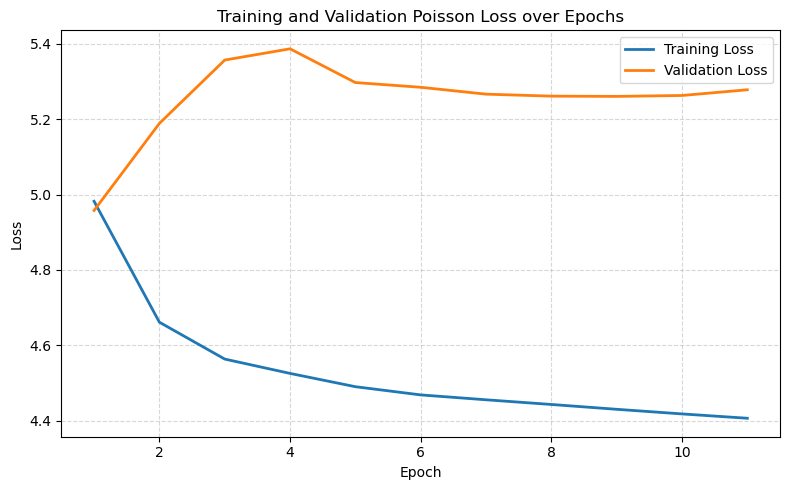

In [29]:
plot_training_history(training_history)


-----------
# 8. Most Exciting Input

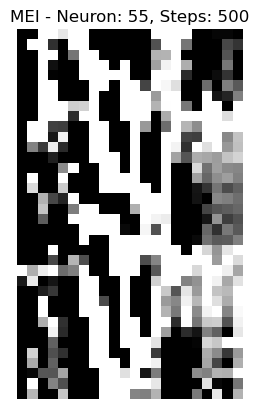

In [30]:
from neuropixel_predictor.mei.generate import generate_mei, plot_mei

device = 'mps'
steps = 500
neuron_idx = 55
image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)

mei = generate_mei(
    model,
    neuron_idx,
    image_shape,
    steps=steps,
    mode="cei",     # or "vei_plus", "vei_minus"
    device=device,
)

plot_mei(mei, title="MEI - Neuron: {}, Steps: {}".format(neuron_idx, steps) )

-----------
# 9. Use MEI in the model

In [31]:
# 1. Fetch a stimulus image from the dataset
random_dataset_indx = torch.randint(training_images.shape[0], (1,))
dataset_image = training_images[random_dataset_indx].to(device)

# 2. Generate a completely random image
random_image = torch.randn(image_shape, device=device) * 0.1

# 3. Test dataset image, random image and MEI image and compare predictions
pred_random = model(random_image)[0, 0, neuron_idx]
pred_dataset = model(dataset_image)[0, 0, neuron_idx]
pred_mei = model(mei)[0, 0, neuron_idx]

pred_random, pred_dataset, pred_mei

(tensor(1.7066, device='mps:0', grad_fn=<SelectBackward0>),
 tensor(1.6793, device='mps:0', grad_fn=<SelectBackward0>),
 tensor(18.3914, device='mps:0', grad_fn=<SelectBackward0>))